In [ ]:
!pip install yfinance
!pip install bt
!pip install wget
!pip install investpy

     |████████████████████████████████| 6.3 MB 35.1 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=86385688a9765d32a9cea5ca2b08051312fb300bc0dccbf13cebbd6f80fb8fca
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 2.7 MB 26.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for bt: filename=bt-0.2.9-cp37-cp37m-linux_x86_64.whl size=765308 sha256=e86aa66ffc0f32ff87a8ff9725dbc84f988f96fb1155820fd10ce9cfd2afc074
  Stored in directory: /root/.cache/pip/wheels/c5/1a/3f/b56e6064b766c107f25e200969161c09ca6868cbfe0eaa31e4
Successfully built bt
  Created wheel for wget: filename=wg

# Carregamento

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_datareader.data as web
import plotly.graph_objects as go
import investpy as inv
import bt
import random
import wget

from scipy.stats import norm, t
from google.colab.data_table import DataTable
from itertools import combinations

## algoritmos
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from keras import Sequential
from keras.layers import Dense, LSTM

## metricas e relatórios
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

## auxiliares pre-processamento e pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler



%matplotlib inline

yf.pdr_override()
sns.set_style('white')

In [ ]:
def consulta_banco_central(codigo_banco_central):
  url= 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_banco_central)
  df = pd.read_json(url)
  df['data'] = pd.to_datetime(df['data'], dayfirst=True)
  df.set_index('data', inplace=True)
  return df
def calcular_indice_acumulado(codigo_banco_central, data_inicio, data_fim):
  indice = consulta_banco_central(codigo_banco_central)
  indice_acumulado = (1 + indice[data_inicio : data_fim] / 100).cumprod()
  indice_acumulado.iloc[0] = 1
  return indice_acumulado
data_inicio = '2001-01-01'
data_fim = '2020-12-31'


In [ ]:
imab = consulta_banco_central(12466)
imab = pd.Series(imab['valor'], index=imab.index)
dolar = consulta_banco_central(1) #dolar livre venda ou dolar compra 10813
dolar = dolar['2000':'2020']
dolar = pd.Series(dolar['valor'], index=dolar.index)
selic = consulta_banco_central(432)
selic = selic['2000':'2020']
selic = pd.Series(selic['valor'], index=selic.index)

In [ ]:
sp500 = yf.download(tickers="^GSPC")['Close']
bovespa = inv.get_index_historical_data('Bovespa', country='brazil', from_date='01/01/1900', to_date='31/12/2020')['Close']
ifix = inv.get_index_historical_data('BM&FBOVESPA Real Estate IFIX', country='brazil', from_date='01/01/1900', to_date='31/12/2020')['Close']
small = inv.get_index_historical_data('Small Cap Index', country='brazil', from_date='01/01/1900', to_date='31/12/2020')['Close']
ouro = inv.get_etf_historical_data('iShares Gold', country='united states', from_date='01/01/1900', to_date='31/12/2020')['Close']
eem = inv.get_etf_historical_data('iShares MSCI Emerging Markets', country='united states', from_date='01/01/1900', to_date='31/12/2020')['Close']

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/investpy/etfs.py:591: Warning:

Selected country does not contain the default stock exchange of the introduced ETF. Default country is: "australia" and default stock_exchange: "Sydney".



# Métodos

In [ ]:
def calculo_desempenho(inicial, final):
  return round(100 * (final - inicial) / inicial, 4)
def calcula_estatisticas_mensais(dados):
  ano = dados.index[1].year
  desempenho = []
  desempenho_jan = calculo_desempenho(dados.iloc[0], dados[f'{ano}-01'].iloc[-1])
  desempenho.append(desempenho_jan)
  for i in range(2, 13):
    desempenho.append(calculo_desempenho(dados[f'{ano}-{i-1}'].iloc[-1], dados[f'{ano}-{i}'].iloc[-1]))
  return pd.Series(index=['Desempenho Jan', 'Desempenho Fev', 'Desempenho Mar', 'Desempenho Abr', 'Desempenho Mai', 'Desempenho Jun', 'Desempenho Jul', 'Desempenho Ago', 'Desempenho Set', 'Desempenho Out', 'Desempenho Nov', 'Desempenho Dez'],
                   data=desempenho)
def rola_valores(s):
  aux = s[0]
  for index, value in s.items():
    if index == 0:
      aux = value
    else:
      if value == 0:
        value = aux;
        s[index] = value
      aux = value
  return s
def calcula_estatisticas_anuais(dados):
  index_geral = ['Desempenho Jan', 'Desempenho Fev', 'Desempenho Mar', 'Desempenho Abr', 'Desempenho Mai', 'Desempenho Jun', 'Desempenho Jul', 'Desempenho Ago', 'Desempenho Set', 'Desempenho Out', 'Desempenho Nov', 'Desempenho Dez']
  df = pd.DataFrame(index=index_geral)
  ano_inicial = dados.index[0].year + 1
  auxiliar = dados[f'{ano_inicial-1}'].index[-1]
  for ano in range(ano_inicial, 2021):
    auxiliar = dados[f'{ano-1}'].index[-1]
    filtro_desempenho = dados[auxiliar:f'{ano}']
    df[f'{ano}'] = calcula_estatisticas_mensais(filtro_desempenho)
                 
  return round(df,2) 

def teste(x):
  if x >= 0 and x < 1:
    x = 1 
  elif x >= 1 and x < 2:
    x = 2
  elif x >= 2:
      x = 3
  elif x < 0 and x > -1:
    x = -1
  elif x <= -1 and x > -2:
    x = -2
  elif x <= -2:
    x = -3
  return x

def gera_df_mensal(dados, ano_inicial):
  df = pd.DataFrame(index=dados.keys())
  for ano in range (ano_inicial,2021):
    for mes in range(1,13):
      s = pd.Series([dados[coluna][f'{ano}'].iloc[mes-1] for coluna in dados.keys() ], index = dados.keys())
      df[f'{ano}-{mes}'] = s
  return df.transpose()

def calcula_percentual_meses2(df):
  serie = pd.Series([(df.loc['Desempenho Jan'] > 0).sum(), (df.loc['Desempenho Fev'] > 0).sum(), (df.loc['Desempenho Mar'] > 0).sum(), (df.loc['Desempenho Abr'] > 0).sum(),
                           (df.loc['Desempenho Mai'] > 0).sum(), (df.loc['Desempenho Jun'] > 0).sum(), (df.loc['Desempenho Jul'] > 0).sum(), (df.loc['Desempenho Ago'] > 0).sum(),
                           (df.loc['Desempenho Set'] > 0).sum(), (df.loc['Desempenho Out'] > 0).sum(), (df.loc['Desempenho Nov'] > 0).sum(), (df.loc['Desempenho Dez'] > 0).sum()],
                    index = ['Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
  numero_anos = len(df.columns)
  return serie / numero_anos

def aplica_n_niveis(dados):
  for coluna in dados.columns:
    dados[coluna] = (dados[coluna] / dados[coluna].std()).apply(teste)

def aplica_2_niveis(dados):
  dados[dados > 0] = 1
  dados[dados < 0] = -1
  if 'Selic' in dados.columns:
    dados['Selic'] = rola_valores(dados['Selic'])

def calcula_sentimento_mensal(df, dados):
  sentimento_mensal = calcula_percentual_meses2(dados['Bovespa'])
  sentimento_mensal[sentimento_mensal > 0.5] = 1
  sentimento_mensal[sentimento_mensal <= 0.5] = -1
  aux = pd.concat([sentimento_mensal]*int(len(df.index)/12), ignore_index=True)
  aux.index = df.index
  df['Sentimento Mensal'] = aux

def Diff(li1, li2):
    return list(set(li1) - set(li2)) + list(set(li2) - set(li1))

def classificadorRandomForest(x_train, y_train, x_test, y_test):
  rfc = RandomForestClassifier(max_depth=2, random_state=0)
  rfc.fit(x_train, y_train)
  y_pred = rfc.predict(x_test)
  return accuracy_score(y_test, y_pred)

def classificadorSVR(x_train, y_train, x_test, y_test):
  regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
  X_train = StandardScaler().fit_transform(x_train)
  X_test = StandardScaler().fit_transform(x_test)
  regr.fit(X_train, y_train)
  y_pred = regr.predict(X_test)
  return ((y_pred > 0) == (y_test > 0)).sum() / len(y_test)

def classificadorSVRsimples(x_train, y_train, x_test, y_test):
  regr = SVR()
  regr.fit(x_train, y_train)
  y_pred = regr.predict(x_test)
  return ((y_pred > 0) == (y_test > 0)).sum() / len(y_test)

def classificadorNaiveBayes(x_train, y_train, x_test, y_test):
  nbc = BernoulliNB()
  nbc.fit(x_train, y_train)
  y_pred = nbc.predict(x_test)
  return accuracy_score(y_test, y_pred)

def classificadorSVC(x_train, y_train, x_test, y_test):  
  svcc = make_pipeline(StandardScaler(), SVC(gamma="auto"))
  svcc.fit(x_train, y_train)
  y_pred = svcc.predict(x_test)
  return accuracy_score(y_test, y_pred)

def classificadorKNN(x_train, y_train, x_test, y_test):   
  knn = KNeighborsClassifier()
  knn.fit(x_train, y_train)
  y_pred = knn.predict(x_test)
  return accuracy_score(y_test, y_pred)

def classificadorMLP(x_train, y_train, x_test, y_test): 
  mlp = make_pipeline(StandardScaler(), MLPClassifier(random_state=0, shuffle=False, max_iter=2000))
  mlp.fit(x_train, y_train)
  y_pred = mlp.predict(x_test)
  return accuracy_score(y_test, y_pred)

def classificadorLR(x_train, y_train, x_test, y_test): 
  lgc = LogisticRegression()
  lgc.fit(x_train, y_train)
  y_pred = lgc.predict(x_test)
  return accuracy_score(y_test, y_pred)

def geraDados():
  dados = {'Dolar': calcula_estatisticas_anuais(dolar),
  'Selic': calcula_estatisticas_anuais(selic),
  'Imab': calcula_estatisticas_anuais(imab),
  'Bovespa': calcula_estatisticas_anuais(bovespa['2000':'2020']),
  'Ifix': calcula_estatisticas_anuais(ifix),
  'SP500': calcula_estatisticas_anuais(sp500['2000':]),
  'Small': calcula_estatisticas_anuais(small),
  'Ouro': calcula_estatisticas_anuais(ouro),
  'Eem': calcula_estatisticas_anuais(eem)}
  return dados

def gerador_dataframe(indices, ano, tipo, sentimento, teste):
  dados = geraDados()

  for key in Diff(indices, list(dados.keys())):
    del dados[key]
  df_mensal = gera_df_mensal(dados, ano)
  
  if tipo == 'N': ## n níveis (-3, -2, -1, 1, 2, 3)
    aplica_n_niveis(df_mensal) 
  elif tipo == '2': ## 2 níveis (0 - 1)
    aplica_2_niveis(df_mensal)
  
  ## aplica sentimento
  if sentimento:
    calcula_sentimento_mensal(df_mensal, dados)

  ## divisão do resultado do resto
  y=df_mensal.Bovespa
  x=df_mensal.drop('Bovespa',axis=1)

  if teste == "N":
    y_test = y[int(len(y.index)*0.7):]
    y_train = y[0:int(len(y.index)*0.7)]
    x_test = x[int(len(x.index)*0.7):]
    x_train = x[0:int(len(x.index)*0.7)]
  else:
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=float(teste))

  ## aplicação de algoritmos
  
  resultados = pd.Series([classificadorRandomForest(x_train, y_train, x_test, y_test),
                          classificadorSVC(x_train, y_train, x_test, y_test),
                          classificadorSVR(x_train, y_train, x_test, y_test),
                          classificadorNaiveBayes(x_train, y_train, x_test, y_test),
                          classificadorKNN(x_train, y_train, x_test, y_test),
                          classificadorLR(x_train, y_train, x_test, y_test),
                          classificadorMLP(x_train, y_train, x_test, y_test)], 
                         index=['Random Forest', 'SVM', 'SVR', 'Naive Bayes Bernoulli', 'K-Nearest Neighbors', 'Regressão Logística', 'Multilayer Perceptron'
                                ])
  return resultados
  ## chamar algoritmo

# Execução

In [ ]:
indice = ['Dolar', 'SP500', 'Ouro', 'Eem', 'Selic', 'Imab', 'Ifix', 'Small']
colunas = ['Configuração', 'Resultado RF', 'Resultado SVM', 'Resultado SVR', 'Resultado NBB', 'Resultado KNN', 'Resultado RLOG', 'Resultado MLP']
anos = pd.Series([dolar.index[0].year, sp500['2000':].index[0].year, ouro.index[0].year, eem.index[0].year, selic.index[0].year, imab.index[0].year, ifix.index[0].year, small.index[0].year], index=indice)
count = 0;
for L in range(1, 3):
    for subset in combinations(indice, L):
        novo_indice = list(subset)
        indice_auxiliar = list(novo_indice)
        novo_indice.insert(0, 'Bovespa')
        for ano in range(anos[indice_auxiliar].max()+1, 2019):
          count +=4
count

1788

In [ ]:
indice = ['Dolar', 'SP500', 'Ouro', 'Eem', 'Selic', 'Imab', 'Ifix', 'Small']
colunas = ['Índices', 'Ano', 'Tipo', 'Sentimento','Resultado RF', 'Resultado SVM', 'Resultado SVR', 'Resultado NBB', 'Resultado KNN', 'Resultado RLOG', 'Resultado MLP']
anos = pd.Series([dolar.index[0].year, sp500['2000':].index[0].year, ouro.index[0].year, eem.index[0].year, selic.index[0].year, imab.index[0].year, ifix.index[0].year, small.index[0].year], index=indice)

resultado_global = pd.DataFrame(columns=colunas)
for L in range(1, 3):
    for subset in combinations(indice, L):
        novo_indice = list(subset)
        indice_auxiliar = list(novo_indice)
        novo_indice.insert(0, 'Bovespa')
        for ano in range(anos[indice_auxiliar].max()+1, 2019):
          tipo = "N"
          sentimento = True
          resultado = gerador_dataframe(novo_indice, ano, tipo, sentimento, "0.3")
          resultado = pd.concat([pd.Series([novo_indice, ano, tipo, sentimento], index=['Ind', 'Ano', 'Tipo', 'Sent']), resultado])
          resultado.index = colunas           
          resultado_global = resultado_global.append(resultado, ignore_index=True)
                    
          sentimento = False
          resultado = gerador_dataframe(novo_indice, ano, tipo, sentimento, "0.3")
          resultado = pd.concat([pd.Series([novo_indice, ano, tipo, sentimento], index=['Ind', 'Ano', 'Tipo', 'Sent']), resultado])
          resultado.index = colunas 
          resultado_global = resultado_global.append(resultado, ignore_index=True)
          
          tipo = "2"
          sentimento = True
          resultado = gerador_dataframe(novo_indice, ano, tipo, sentimento, "0.3")
          resultado = pd.concat([pd.Series([novo_indice, ano, tipo, sentimento], index=['Ind', 'Ano', 'Tipo', 'Sent']), resultado])
          resultado.index = colunas 
          resultado_global = resultado_global.append(resultado, ignore_index=True)
          
          sentimento = False
          resultado = gerador_dataframe(novo_indice, ano, tipo, sentimento, "0.3")
          resultado = pd.concat([pd.Series([novo_indice, ano, tipo, sentimento], index=['Ind', 'Ano', 'Tipo', 'Sent']), resultado])
          resultado.index = colunas 
          resultado_global = resultado_global.append(resultado, ignore_index=True)

writer = pd.ExcelWriter('Resultados.xlsx')
resultado_global.to_excel(writer)
writer.save()


In [ ]:
colunas = ['Índices', 'Ano', 'Sentimento', 'Treino','Resultado RF', 'Resultado SVM', 'Resultado SVR', 'Resultado NBB', 'Resultado KNN', 'Resultado RLOG', 'Resultado MLP']
resultado_global = pd.DataFrame(columns=colunas)
novo_indice = ['Bovespa', 'Dolar', 'SP500', 'Ouro', 'Eem', 'Selic', 'Imab', 'Small']
ano = 2008
tipo = "N"
sentimento = True


In [ ]:
tipo = "N"
sentimento = True
resultado = gerador_dataframe(novo_indice, ano, tipo, sentimento, "0.3")
resultado = pd.concat([pd.Series([novo_indice, ano, tipo, sentimento], index=['Ind', 'Ano', 'Sent', 'Treino']), resultado])
resultado.index = colunas           
resultado_global = resultado_global.append(resultado, ignore_index=True)
          
sentimento = False
resultado = gerador_dataframe(novo_indice, ano, tipo, sentimento, "0.3")
resultado = pd.concat([pd.Series([novo_indice, ano, tipo, sentimento], index=['Ind', 'Ano', 'Sent', 'Treino']), resultado])
resultado.index = colunas 
resultado_global = resultado_global.append(resultado, ignore_index=True)

tipo = "2"
sentimento = True
resultado = gerador_dataframe(novo_indice, ano, tipo, sentimento, "0.3")
resultado = pd.concat([pd.Series([novo_indice, ano, tipo, sentimento], index=['Ind', 'Ano', 'Sent', 'Treino']), resultado])
resultado.index = colunas 
resultado_global = resultado_global.append(resultado, ignore_index=True)

sentimento = False
resultado = gerador_dataframe(novo_indice, ano, tipo, sentimento, "0.3")
resultado = pd.concat([pd.Series([novo_indice, ano, tipo, sentimento], index=['Ind', 'Ano', 'Sent', 'Treino']), resultado])
resultado.index = colunas 
resultado_global = resultado_global.append(resultado, ignore_index=True)

In [ ]:
resultado_global = resultado_global.append(resultado, ignore_index=True)

In [ ]:
a = ['Bovespa', 'Dolar', 'SP500', 'Ouro', 'Eem', 'Selic']

In [ ]:
resultado_global[resultado_global['Ano'] == 2006]['Resultado MLP'].max()

0.8888888888888888

In [ ]:
resultado_global['Índices'][0][0]

'Bovespa'

In [ ]:
writer = pd.ExcelWriter('output2.xlsx')


In [ ]:
resultado_global.to_excel(writer)
writer.save()

In [ ]:
resultado_global.to_csv('teste2.csv')

# Resultados

## Carregamento

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

sns.set_style('white')

In [ ]:
resultados = pd.read_excel('/content/Resultado_simulacao.xlsx', index_col=0)

In [ ]:
resultados.tail()

,Indices,Ano,Tipo,Sentimento,Resultado RF,Resultado SVM,Resultado SVR,Resultado NBB,Resultado KNN,Resultado RLOG,Resultado MLP
9427,"['Bovespa', 'Dolar', 'SP500', 'Ouro', 'Eem', '...",2017,2,False,0.866667,0.800000,0.733333,0.866667,0.866667,0.800000,0.800000
9428,"['Bovespa', 'Dolar', 'SP500', 'Ouro', 'Eem', '...",2018,N,True,0.454545,0.454545,0.636364,0.272727,0.363636,0.272727,0.181818
9429,"['Bovespa', 'Dolar', 'SP500', 'Ouro', 'Eem', '...",2018,N,False,0.727273,0.545455,0.818182,0.545455,0.545455,0.727273,0.727273
9430,"['Bovespa', 'Dolar', 'SP500', 'Ouro', 'Eem', '...",2018,2,True,0.818182,0.818182,0.818182,0.818182,0.909091,0.909091,1.000000
9431,"['Bovespa', 'Dolar', 'SP500', 'Ouro', 'Eem', '...",2018,2,False,0.909091,0.909091,0.818182,0.909091,0.909091,0.909091,0.909091


In [ ]:
resultados.Indices = resultados.Indices.apply(eval)

## Análise Geral

In [ ]:
resultados.describe()

,Ano,Resultado RF,Resultado SVM,Resultado SVR,Resultado NBB,Resultado KNN,Resultado RLOG,Resultado MLP
count,9432.00000,9432.000000,9432.000000,9432.000000,9432.000000,9432.000000,9432.000000,9432.000000
mean,2012.85369,0.626837,0.612682,0.762583,0.616491,0.608279,0.633518,0.606779
std,3.98856,0.180538,0.182928,0.098357,0.196373,0.187551,0.178863,0.185693
min,2001.00000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000
25%,2010.00000,0.477273,0.466667,0.722222,0.454545,0.454545,0.500000,0.454545
50%,2014.00000,0.636364,0.611111,0.772727,0.611111,0.608696,0.636364,0.611111
75%,2016.00000,0.784314,0.772727,0.825000,0.800000,0.772727,0.787879,0.772727
max,2018.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


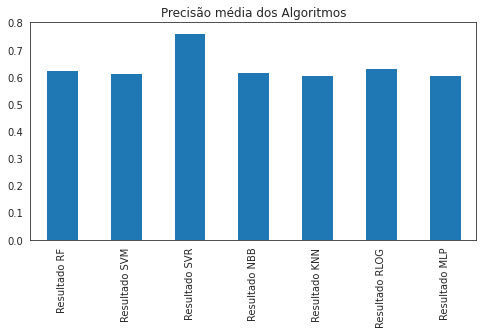

In [ ]:
resultados.drop(['Ano', 'Sentimento', 'Tipo'], axis=1).mean().plot(kind='bar', title='Precisão média dos Algoritmos', figsize=(8,4))

In [ ]:
resultados.drop(['Sentimento'], axis=1).groupby(['Ano']).mean()

,Resultado RF,Resultado SVM,Resultado SVR,Resultado NBB,Resultado KNN,Resultado RLOG,Resultado MLP
Ano,,,,,,,
2001,0.586310,0.588294,0.707837,0.579365,0.553571,0.586310,0.590774
2002,0.587992,0.594720,0.722050,0.583851,0.561594,0.589027,0.598344
2003,0.570330,0.579670,0.715385,0.573077,0.558242,0.582418,0.582967
2004,0.606720,0.610484,0.753226,0.599731,0.565591,0.617204,0.609677
2005,0.622080,0.624027,0.758482,0.618604,0.587875,0.632369,0.610679
2006,0.640675,0.628828,0.775080,0.622959,0.612387,0.652596,0.629046
2007,0.648140,0.639339,0.771345,0.629497,0.619114,0.658638,0.632932
2008,0.656852,0.652915,0.784009,0.647303,0.637712,0.669333,0.644120
2009,0.642224,0.639943,0.768253,0.624463,0.626387,0.656496,0.634753


In [ ]:
a = resultados.drop(['Sentimento', 'Tipo'], axis=1).groupby(['Ano']).mean()

In [ ]:
a.index = a.index.map(str)

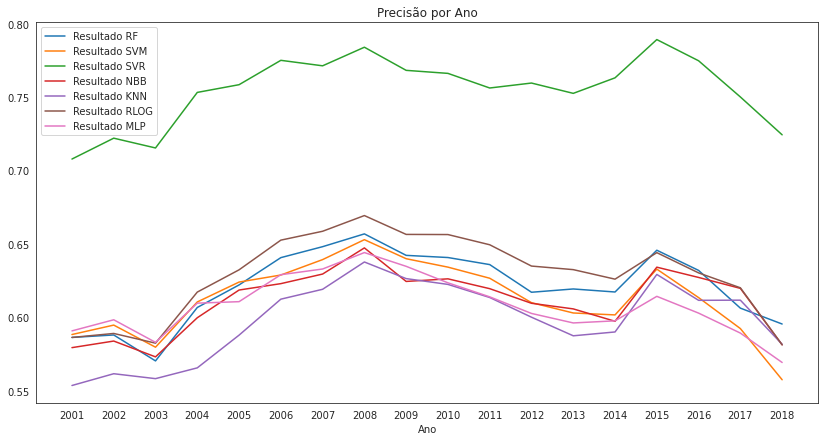

In [ ]:
resultados.drop(['Sentimento', 'Tipo'], axis=1).groupby(['Ano']).mean().plot(figsize=(14,7), xticks=range(2001,2019), title='Precisão por Ano')

In [ ]:
resultados.drop(['Sentimento', 'Ano'], axis=1).groupby(['Tipo']).mean()

,Resultado RF,Resultado SVM,Resultado SVR,Resultado NBB,Resultado KNN,Resultado RLOG,Resultado MLP
Tipo,,,,,,,
2,0.775594,0.762759,0.760912,0.787304,0.762658,0.779270,0.761797
N,0.478081,0.462604,0.764253,0.445679,0.453899,0.487765,0.451762


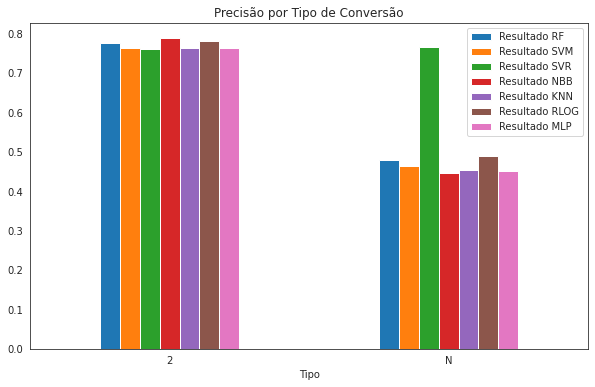

In [ ]:
resultados.drop(['Sentimento', 'Ano'], axis=1).groupby(['Tipo']).mean().plot(kind="bar", figsize=(10,6), title='Precisão por Tipo de Conversão', rot=0)

In [ ]:
resultados.drop(['Tipo', 'Ano'], axis=1).groupby(['Sentimento']).mean()

,Resultado RF,Resultado SVM,Resultado SVR,Resultado NBB,Resultado KNN,Resultado RLOG,Resultado MLP
Sentimento,,,,,,,
False,0.626625,0.613616,0.760722,0.612148,0.606858,0.633488,0.607898
True,0.627049,0.611747,0.764443,0.620835,0.609700,0.633547,0.605661


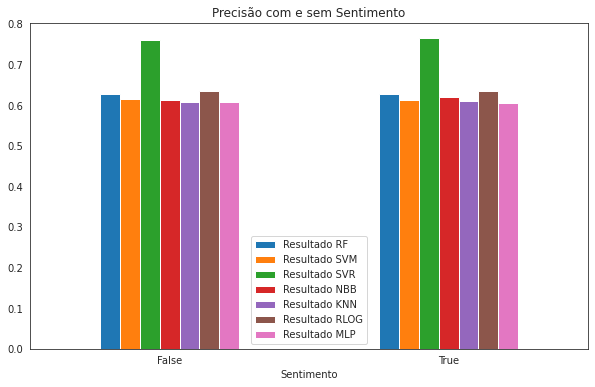

In [ ]:
resultados.drop(['Tipo', 'Ano'], axis=1).groupby(['Sentimento']).mean().plot(kind="bar", rot=0, figsize=(10,6), title='Precisão com e sem Sentimento')

In [ ]:
a = resultados.loc[resultados.Indices.map(lambda x: 'Small' not in x)]


In [ ]:
resultados.tail()['Indices']

9427    [Bovespa, Dolar, SP500, Ouro, Eem, Selic, Imab...
9428    [Bovespa, Dolar, SP500, Ouro, Eem, Selic, Imab...
9429    [Bovespa, Dolar, SP500, Ouro, Eem, Selic, Imab...
9430    [Bovespa, Dolar, SP500, Ouro, Eem, Selic, Imab...
9431    [Bovespa, Dolar, SP500, Ouro, Eem, Selic, Imab...
Name: Indices, dtype: object

In [ ]:
a.drop(['Ano', 'Sentimento'], axis=1).mean()

Resultado RF      0.590218
Resultado SVM     0.577891
Resultado SVR     0.725922
Resultado NBB     0.587341
Resultado KNN     0.571480
Resultado RLOG    0.597272
Resultado MLP     0.572411
dtype: float64

In [ ]:
colunas_dropadas = ['Sentimento', 'Ano', 'Tipo', 'Indices']
a = resultados.loc[resultados.Indices.map(lambda x: 'Small' not in x)].drop(colunas_dropadas, axis=1).mean()
indice = a.index

In [ ]:
a

Resultado RF      0.590218
Resultado SVM     0.577891
Resultado SVR     0.725922
Resultado NBB     0.587341
Resultado KNN     0.571480
Resultado RLOG    0.597272
Resultado MLP     0.572411
dtype: float64

In [ ]:
b = pd.DataFrame(
    {'Small': resultados.loc[resultados.Indices.map(lambda x: 'Small' not in x)].drop(colunas_dropadas, axis=1).mean(),
     'Dolar': resultados.loc[resultados.Indices.map(lambda x: 'Dolar' not in x)].drop(colunas_dropadas, axis=1).mean(),
     'Selic': resultados.loc[resultados.Indices.map(lambda x: 'Selic' not in x)].drop(colunas_dropadas, axis=1).mean(),
     'SP500': resultados.loc[resultados.Indices.map(lambda x: 'SP500' not in x)].drop(colunas_dropadas, axis=1).mean(),
     'Eem': resultados.loc[resultados.Indices.map(lambda x: 'Eem' not in x)].drop(colunas_dropadas, axis=1).mean(),
     'Ouro': resultados.loc[resultados.Indices.map(lambda x: 'Ouro' not in x)].drop(colunas_dropadas, axis=1).mean(),
     'Ifix': resultados.loc[resultados.Indices.map(lambda x: 'Ifix' not in x)].drop(colunas_dropadas, axis=1).mean(),
     'Imab': resultados.loc[resultados.Indices.map(lambda x: 'Imab' not in x)].drop(colunas_dropadas, axis=1).mean()
     }, index=indice
)

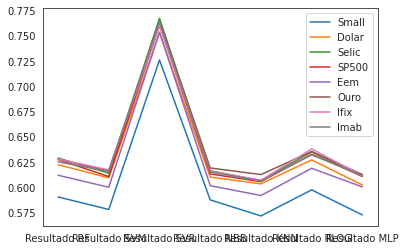

In [ ]:
b.plot()

In [ ]:
(b.mean().sort_values()*100).round(2)

Small    60.32
Eem      62.53
Dolar    63.24
SP500    63.72
Imab     63.84
Ifix     63.95
Selic    63.97
Ouro     64.11
dtype: float64

In [ ]:
c = pd.DataFrame(
    {'Small': resultados.loc[resultados.Indices.map(lambda x: 'Small' in x)].drop(colunas_dropadas, axis=1).mean(),
     'Dolar': resultados.loc[resultados.Indices.map(lambda x: 'Dolar' in x)].drop(colunas_dropadas, axis=1).mean(),
     'Selic': resultados.loc[resultados.Indices.map(lambda x: 'Selic' in x)].drop(colunas_dropadas, axis=1).mean(),
     'SP500': resultados.loc[resultados.Indices.map(lambda x: 'SP500' in x)].drop(colunas_dropadas, axis=1).mean(),
     'Eem': resultados.loc[resultados.Indices.map(lambda x: 'Eem' in x)].drop(colunas_dropadas, axis=1).mean(),
     'Ouro': resultados.loc[resultados.Indices.map(lambda x: 'Ouro' in x)].drop(colunas_dropadas, axis=1).mean(),
     'Ifix': resultados.loc[resultados.Indices.map(lambda x: 'Ifix' in x)].drop(colunas_dropadas, axis=1).mean(),
     'Imab': resultados.loc[resultados.Indices.map(lambda x: 'Imab' in x)].drop(colunas_dropadas, axis=1).mean()
     }, index=indice
)

In [ ]:
c

,Small,Dolar,Selic,SP500,Eem,Ouro,Ifix,Imab
Resultado RF,0.665172,0.631332,0.624915,0.626360,0.641966,0.625787,0.624601,0.628672
Resultado SVM,0.649103,0.616163,0.611614,0.614842,0.625569,0.609139,0.600799,0.609770
Resultado SVR,0.800962,0.772209,0.758001,0.764766,0.771683,0.760460,0.770215,0.761356
Resultado NBB,0.647008,0.622920,0.616755,0.619860,0.631635,0.613897,0.618483,0.618081
Resultado KNN,0.646802,0.613228,0.610168,0.611073,0.624956,0.603920,0.612111,0.610585
Resultado RLOG,0.671462,0.640005,0.631942,0.634363,0.648469,0.631698,0.621992,0.635112
Resultado MLP,0.642759,0.611406,0.603125,0.602849,0.613426,0.600812,0.594835,0.601970


In [ ]:
(c.mean().sort_values()*100).round(2)

Ifix     63.47
Ouro     63.51
Selic    63.66
Imab     63.79
SP500    63.92
Dolar    64.39
Eem      65.11
Small    67.48
dtype: float64

In [ ]:
(c.subtract(b)*100)


,Small,Dolar,Selic,SP500,Eem,Ouro,Ifix,Imab
Resultado RF,7.495365,0.905809,-0.387281,-0.096205,3.018167,-0.205353,-0.306913,0.363685
Resultado SVM,7.121214,0.701587,-0.215054,0.435397,2.571027,-0.692576,-1.630898,-0.577013
Resultado SVR,7.503960,1.940041,-0.923397,0.440048,1.815407,-0.415109,1.047537,-0.243080
Resultado NBB,5.966630,1.295550,0.053225,0.678988,3.020947,-0.507237,0.273327,0.314928
Resultado KNN,7.532243,0.997421,0.380799,0.563256,3.327010,-0.852298,0.525935,0.457084
Resultado RLOG,7.419019,1.307518,-0.317482,0.170354,2.982738,-0.355696,-1.581934,0.315966
Resultado MLP,7.034836,0.932365,-0.736594,-0.792104,1.326008,-1.166835,-1.639439,-0.952942


In [ ]:
((c.subtract(b)).mean()*100).sort_values().round(2)


Ouro    -0.60
Ifix    -0.47
Selic   -0.31
Imab    -0.05
SP500    0.20
Dolar    1.15
Eem      2.58
Small    7.15
dtype: float64

In [ ]:
c

,Small,Dolar,Selic,SP500,Eem,Ouro,Ifix,Imab
Resultado RF,0.665172,0.631332,0.624915,0.626360,0.641966,0.625787,0.624601,0.628672
Resultado SVM,0.649103,0.616163,0.611614,0.614842,0.625569,0.609139,0.600799,0.609770
Resultado SVR,0.800962,0.772209,0.758001,0.764766,0.771683,0.760460,0.770215,0.761356
Resultado NBB,0.647008,0.622920,0.616755,0.619860,0.631635,0.613897,0.618483,0.618081
Resultado KNN,0.646802,0.613228,0.610168,0.611073,0.624956,0.603920,0.612111,0.610585
Resultado RLOG,0.671462,0.640005,0.631942,0.634363,0.648469,0.631698,0.621992,0.635112
Resultado MLP,0.642759,0.611406,0.603125,0.602849,0.613426,0.600812,0.594835,0.601970


In [ ]:
c.div(b).sub(1)*100

,Small,Dolar,Selic,SP500,Eem,Ouro,Ifix,Imab
Resultado RF,12.699306,1.455645,-0.615916,-0.153358,4.933381,-0.327079,-0.488972,0.581863
Resultado SVM,12.322766,1.151754,-0.350385,0.713194,4.286052,-1.124193,-2.642808,-0.937410
Resultado SVR,10.337143,2.577072,-1.203538,0.578733,2.409208,-0.542903,1.378811,-0.318257
Resultado NBB,10.158708,2.123977,0.086374,1.107520,5.022981,-0.819486,0.443894,0.512135
Resultado KNN,13.180241,1.653402,0.628007,0.930324,5.622933,-1.391638,0.866663,0.754247
Resultado RLOG,12.421508,2.085588,-0.499879,0.269266,4.821429,-0.559926,-2.480255,0.499984
Resultado MLP,12.289839,1.548569,-1.206561,-1.296894,2.209401,-1.905100,-2.682201,-1.558369


###Analise dos resultados Máximos

In [ ]:
resultados['Resultado RF'].max()

1.0

In [ ]:
resultados[resultados['Resultado RF'] == 1].count()['Indices']

44

In [ ]:
resultados[resultados['Resultado RF'] == 1]['Ano'].min()

2015

In [ ]:
resultados[resultados['Resultado SVM'] == 1].count()['Indices']

34

In [ ]:
resultados[resultados['Resultado SVM'] == 1]['Ano'].min()

2015

In [ ]:
resultados[resultados['Resultado SVR'] == 1].count()['Indices']

65

In [ ]:
resultados[resultados['Resultado SVR'] == 1]['Ano'].min()

2015

In [ ]:
resultados[resultados['Resultado NBB'] == 1].count()['Indices']

54

In [ ]:
resultados[resultados['Resultado NBB'] == 1]['Ano'].min()

2014

In [ ]:
resultados[resultados['Resultado KNN'] == 1].count()['Indices']

35

In [ ]:
resultados[resultados['Resultado KNN'] == 1]['Ano'].min()

2015

In [ ]:
resultados[resultados['Resultado RLOG'] == 1].count()['Indices']

52

In [ ]:
resultados[resultados['Resultado RLOG'] == 1]['Ano'].min()

2014

In [ ]:
resultados[resultados['Resultado MLP'] == 1].count()['Indices']

39

In [ ]:
resultados[resultados['Resultado MLP'] == 1]['Ano'].min()

2015

In [ ]:
maximas_and = resultados[(resultados['Resultado MLP'] == 1) 
          & (resultados['Resultado RLOG'] == 1)
          & (resultados['Resultado RF'] == 1)
          & (resultados['Resultado KNN'] == 1)
          & (resultados['Resultado SVM'] == 1)
          & (resultados['Resultado SVR'] == 1)
          & (resultados['Resultado NBB'] == 1)]

In [ ]:
maximas_and.groupby(['Ano']).count()

,Indices,Tipo,Sentimento,Resultado RF,Resultado SVM,Resultado SVR,Resultado NBB,Resultado KNN,Resultado RLOG,Resultado MLP
Ano,,,,,,,,,,
2015,2,2,2,2,2,2,2,2,2,2
2016,4,4,4,4,4,4,4,4,4,4
2018,4,4,4,4,4,4,4,4,4,4


In [ ]:
maximas_and.groupby(['Sentimento']).describe()

Ano                                 ... Resultado MLP               
           count         mean       std     min  ...           25%  50%  75%  max
Sentimento                                       ...                             
False        6.0  2016.333333  1.366260  2015.0  ...           1.0  1.0  1.0  1.0
True         4.0  2017.000000  1.154701  2016.0  ...           1.0  1.0  1.0  1.0

[2 rows x 64 columns]

In [ ]:
maximas_or = resultados[(resultados['Resultado MLP'] == 1) 
          | (resultados['Resultado RLOG'] == 1)
          | (resultados['Resultado RF'] == 1)
          | (resultados['Resultado KNN'] == 1)
          | (resultados['Resultado SVM'] == 1)
          | (resultados['Resultado SVR'] == 1)
          | (resultados['Resultado NBB'] == 1)]

In [ ]:
maximas_or['Ano'].min()

2014

In [ ]:
maximas_or.groupby(['Tipo']).describe()

Ano                        ... Resultado MLP                    
      count        mean       std  ...           50%       75%       max
Tipo                               ...                                  
2     105.0  2017.12381  1.080378  ...      0.909091  1.000000  1.000000
N      26.0  2017.00000  1.166190  ...      0.454545  0.545455  0.636364

[2 rows x 64 columns]

In [ ]:
maximas_or.groupby(['Ano']).describe()

Resultado RF                      ... Resultado MLP                    
            count      mean       std  ...           50%       75%       max
Ano                                    ...                                  
2014          1.0  0.961538       NaN  ...      0.769231  0.769231  0.769231
2015         14.0  0.850649  0.210522  ...      0.863636  0.977273  1.000000
2016         24.0  0.863426  0.201297  ...      0.916667  1.000000  1.000000
2017         24.0  0.833333  0.187534  ...      0.866667  0.933333  1.000000
2018         68.0  0.823529  0.196103  ...      0.909091  1.000000  1.000000

[5 rows x 56 columns]

In [ ]:
maximas_or.groupby(['Sentimento']).describe()

Ano                         ... Resultado MLP               
           count         mean       std  ...           50%       75%  max
Sentimento                               ...                             
False       48.0  2017.229167  1.036352  ...      0.909091  1.000000  1.0
True        83.0  2017.024096  1.125924  ...      0.818182  0.944444  1.0

[2 rows x 64 columns]

###Análise dos resultados Mínimos

In [ ]:
resultados[resultados['Resultado RF'] == 0]

,Indices,Ano,Tipo,Sentimento,Resultado RF,Resultado SVM,Resultado SVR,Resultado NBB,Resultado KNN,Resultado RLOG,Resultado MLP
1305,"[Bovespa, Ouro, Imab]",2018,N,False,0.0,0.0,0.636364,0.090909,0.090909,0.000000,0.000000
7268,"[Bovespa, Dolar, SP500, Selic, Imab, Ifix]",2018,N,True,0.0,0.0,0.545455,0.272727,0.272727,0.090909,0.181818


In [ ]:
resultados[resultados['Resultado SVM'] == 0]

,Indices,Ano,Tipo,Sentimento,Resultado RF,Resultado SVM,Resultado SVR,Resultado NBB,Resultado KNN,Resultado RLOG,Resultado MLP
1305,"[Bovespa, Ouro, Imab]",2018,N,False,0.000000,0.0,0.636364,0.090909,0.090909,0.000000,0.000000
1436,"[Bovespa, Eem, Selic]",2018,N,True,0.272727,0.0,0.454545,0.000000,0.000000,0.000000,0.272727
3225,"[Bovespa, SP500, Selic, Ifix]",2018,N,False,0.090909,0.0,0.545455,0.181818,0.181818,0.181818,0.272727
7176,"[Bovespa, Dolar, SP500, Eem, Imab, Ifix]",2018,N,True,0.181818,0.0,0.727273,0.272727,0.181818,0.272727,0.000000
7268,"[Bovespa, Dolar, SP500, Selic, Imab, Ifix]",2018,N,True,0.000000,0.0,0.545455,0.272727,0.272727,0.090909,0.181818


In [ ]:
resultados[resultados['Resultado NBB'] == 0]

,Indices,Ano,Tipo,Sentimento,Resultado RF,Resultado SVM,Resultado SVR,Resultado NBB,Resultado KNN,Resultado RLOG,Resultado MLP
1436,"[Bovespa, Eem, Selic]",2018,N,True,0.272727,0.0,0.454545,0.0,0.0,0.0,0.272727


In [ ]:
resultados[resultados['Resultado KNN'] == 0]

,Indices,Ano,Tipo,Sentimento,Resultado RF,Resultado SVM,Resultado SVR,Resultado NBB,Resultado KNN,Resultado RLOG,Resultado MLP
1436,"[Bovespa, Eem, Selic]",2018,N,True,0.272727,0.0,0.454545,0.0,0.0,0.0,0.272727


In [ ]:
resultados[resultados['Resultado RLOG'] == 0]

,Indices,Ano,Tipo,Sentimento,Resultado RF,Resultado SVM,Resultado SVR,Resultado NBB,Resultado KNN,Resultado RLOG,Resultado MLP
1305,"[Bovespa, Ouro, Imab]",2018,N,False,0.000000,0.000000,0.636364,0.090909,0.090909,0.0,0.000000
1436,"[Bovespa, Eem, Selic]",2018,N,True,0.272727,0.000000,0.454545,0.000000,0.000000,0.0,0.272727
4001,"[Bovespa, Selic, Imab, Ifix]",2018,N,False,0.272727,0.272727,0.727273,0.272727,0.363636,0.0,0.181818
6412,"[Bovespa, Ouro, Selic, Imab, Ifix]",2018,N,True,0.181818,0.181818,0.727273,0.181818,0.181818,0.0,0.363636


In [ ]:
resultados[resultados['Resultado MLP'] == 0]

,Indices,Ano,Tipo,Sentimento,Resultado RF,Resultado SVM,Resultado SVR,Resultado NBB,Resultado KNN,Resultado RLOG,Resultado MLP
1305,"[Bovespa, Ouro, Imab]",2018,N,False,0.000000,0.000000,0.636364,0.090909,0.090909,0.000000,0.0
7176,"[Bovespa, Dolar, SP500, Eem, Imab, Ifix]",2018,N,True,0.181818,0.000000,0.727273,0.272727,0.181818,0.272727,0.0
8893,"[Bovespa, Dolar, SP500, Selic, Imab, Ifix, Small]",2018,N,False,0.363636,0.363636,0.727273,0.454545,0.363636,0.272727,0.0


In [ ]:
minimas_or = resultados[(resultados['Resultado MLP'] == 0) 
          | (resultados['Resultado RLOG'] == 0)
          | (resultados['Resultado RF'] == 0)
          | (resultados['Resultado KNN'] == 0)
          | (resultados['Resultado SVM'] == 0)
          | (resultados['Resultado SVR'] == 0)
          | (resultados['Resultado NBB'] == 0)]

In [ ]:
minimas_or

,Indices,Ano,Tipo,Sentimento,Resultado RF,Resultado SVM,Resultado SVR,Resultado NBB,Resultado KNN,Resultado RLOG,Resultado MLP
1305,"[Bovespa, Ouro, Imab]",2018,N,False,0.000000,0.000000,0.636364,0.090909,0.090909,0.000000,0.000000
1436,"[Bovespa, Eem, Selic]",2018,N,True,0.272727,0.000000,0.454545,0.000000,0.000000,0.000000,0.272727
3225,"[Bovespa, SP500, Selic, Ifix]",2018,N,False,0.090909,0.000000,0.545455,0.181818,0.181818,0.181818,0.272727
4001,"[Bovespa, Selic, Imab, Ifix]",2018,N,False,0.272727,0.272727,0.727273,0.272727,0.363636,0.000000,0.181818
6412,"[Bovespa, Ouro, Selic, Imab, Ifix]",2018,N,True,0.181818,0.181818,0.727273,0.181818,0.181818,0.000000,0.363636
7176,"[Bovespa, Dolar, SP500, Eem, Imab, Ifix]",2018,N,True,0.181818,0.000000,0.727273,0.272727,0.181818,0.272727,0.000000
7268,"[Bovespa, Dolar, SP500, Selic, Imab, Ifix]",2018,N,True,0.000000,0.000000,0.545455,0.272727,0.272727,0.090909,0.181818
8893,"[Bovespa, Dolar, SP500, Selic, Imab, Ifix, Small]",2018,N,False,0.363636,0.363636,0.727273,0.454545,0.363636,0.272727,0.000000


## Análise por Combinação

Divisão dos resultados por número de índices combinados

In [ ]:
comb2 = resultados.loc[resultados.Indices.map(lambda x: len(x) == 2)]
comb3 = resultados.loc[resultados.Indices.map(lambda x: len(x) == 3)]
comb4 = resultados.loc[resultados.Indices.map(lambda x: len(x) == 4)]
comb5 = resultados.loc[resultados.Indices.map(lambda x: len(x) == 5)]
comb6 = resultados.loc[resultados.Indices.map(lambda x: len(x) == 6)]
comb7 = resultados.loc[resultados.Indices.map(lambda x: len(x) == 7)]
comb8 = resultados.loc[resultados.Indices.map(lambda x: len(x) == 8)]
comb9 = resultados.loc[resultados.Indices.map(lambda x: len(x) == 9)]

Descrição das médias para cada subconjunto de itens combinados

In [ ]:
comb2.describe()

,Ano,Resultado RF,Resultado SVM,Resultado SVR,Resultado NBB,Resultado KNN,Resultado RLOG,Resultado MLP
count,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000
mean,2010.798246,0.565467,0.563708,0.694521,0.553055,0.528437,0.565256,0.567694
std,4.786758,0.172943,0.170945,0.111784,0.175034,0.182633,0.167636,0.166774
min,2001.000000,0.090909,0.090909,0.384615,0.090909,0.090909,0.090909,0.090909
25%,2007.000000,0.442204,0.425926,0.619773,0.416667,0.384615,0.447909,0.444444
50%,2011.000000,0.555556,0.554374,0.701064,0.549510,0.522902,0.564516,0.569098
75%,2015.000000,0.692842,0.692842,0.776341,0.681818,0.666667,0.682932,0.681818
max,2018.000000,0.944444,0.944444,0.944444,0.944444,0.944444,0.944444,0.944444


In [ ]:
comb3.describe()

,Ano,Resultado RF,Resultado SVM,Resultado SVR,Resultado NBB,Resultado KNN,Resultado RLOG,Resultado MLP
count,1332.000000,1332.000000,1332.000000,1332.000000,1332.000000,1332.000000,1332.000000,1332.000000
mean,2011.795796,0.595873,0.592853,0.739268,0.588664,0.576948,0.606082,0.596280
std,4.322851,0.177727,0.180369,0.103516,0.186007,0.181674,0.174872,0.179027
min,2001.000000,0.000000,0.000000,0.363636,0.000000,0.000000,0.000000,0.000000
25%,2008.000000,0.454545,0.454545,0.666667,0.444444,0.431034,0.467999,0.454545
50%,2012.000000,0.590909,0.590909,0.750000,0.575379,0.574734,0.611111,0.594169
75%,2016.000000,0.750000,0.744681,0.818182,0.754779,0.727273,0.757576,0.746324
max,2018.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
comb4.describe()

,Ano,Resultado RF,Resultado SVM,Resultado SVR,Resultado NBB,Resultado KNN,Resultado RLOG,Resultado MLP
count,2308.000000,2308.000000,2308.000000,2308.000000,2308.000000,2308.000000,2308.000000,2308.000000
mean,2012.499133,0.622009,0.608719,0.756582,0.610098,0.604466,0.631590,0.609261
std,3.986159,0.178941,0.183108,0.098141,0.194864,0.183402,0.177334,0.184926
min,2001.000000,0.090909,0.000000,0.090909,0.090909,0.055556,0.000000,0.066667
25%,2009.000000,0.475000,0.462607,0.709677,0.450000,0.454545,0.500000,0.454545
50%,2013.000000,0.636364,0.611111,0.769231,0.600000,0.607843,0.636364,0.614510
75%,2016.000000,0.775000,0.769231,0.818182,0.787234,0.764706,0.777778,0.772727
max,2018.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
comb5.describe()

,Ano,Resultado RF,Resultado SVM,Resultado SVR,Resultado NBB,Resultado KNN,Resultado RLOG,Resultado MLP
count,2544.000000,2544.000000,2544.000000,2544.000000,2544.000000,2544.000000,2544.000000,2544.000000
mean,2013.033019,0.637749,0.619954,0.770328,0.626576,0.618367,0.642398,0.610136
std,3.793802,0.178286,0.181493,0.092325,0.197144,0.187095,0.179796,0.188499
min,2004.000000,0.090909,0.090909,0.272727,0.090909,0.090909,0.000000,0.090909
25%,2010.000000,0.500000,0.466667,0.727273,0.454545,0.461538,0.500000,0.454545
50%,2014.000000,0.638593,0.625000,0.777778,0.636364,0.628540,0.653846,0.613636
75%,2016.000000,0.795665,0.777778,0.828136,0.805556,0.777778,0.800000,0.777778
max,2018.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
comb6.describe()

,Ano,Resultado RF,Resultado SVM,Resultado SVR,Resultado NBB,Resultado KNN,Resultado RLOG,Resultado MLP
count,1796.000000,1796.000000,1796.000000,1796.000000,1796.000000,1796.000000,1796.000000,1796.000000
mean,2013.543430,0.644854,0.626197,0.779684,0.633878,0.625786,0.651520,0.612712
std,3.641728,0.181638,0.182780,0.091213,0.199724,0.187839,0.177890,0.189465
min,2005.000000,0.000000,0.000000,0.363636,0.133333,0.090909,0.090909,0.000000
25%,2011.000000,0.500000,0.472222,0.727273,0.454545,0.466667,0.510638,0.454545
50%,2014.000000,0.653846,0.636364,0.787234,0.636364,0.636364,0.666667,0.617021
75%,2016.000000,0.807692,0.777778,0.833333,0.818182,0.793103,0.807692,0.777778
max,2018.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
comb7.describe()

,Ano,Resultado RF,Resultado SVM,Resultado SVR,Resultado NBB,Resultado KNN,Resultado RLOG,Resultado MLP
count,784.000000,784.000000,784.000000,784.000000,784.000000,784.000000,784.000000,784.000000
mean,2014.142857,0.647374,0.625335,0.787200,0.640507,0.635419,0.650422,0.613392
std,3.400849,0.183249,0.189501,0.090804,0.201044,0.191221,0.180073,0.186616
min,2006.000000,0.181818,0.090909,0.272727,0.090909,0.181818,0.090909,0.000000
25%,2012.750000,0.500000,0.469962,0.727273,0.454545,0.466667,0.500000,0.461538
50%,2015.000000,0.666667,0.636364,0.800000,0.666667,0.636364,0.666667,0.611111
75%,2017.000000,0.807692,0.785205,0.846154,0.818182,0.807692,0.807692,0.777778
max,2018.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
comb8.describe()

,Ano,Resultado RF,Resultado SVM,Resultado SVR,Resultado NBB,Resultado KNN,Resultado RLOG,Resultado MLP
count,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000
mean,2014.916667,0.642318,0.633527,0.789872,0.639854,0.647108,0.651386,0.612468
std,2.907534,0.185511,0.186935,0.093043,0.212691,0.194650,0.181398,0.190359
min,2006.000000,0.181818,0.181818,0.454545,0.166667,0.222222,0.266667,0.166667
25%,2014.000000,0.500000,0.466667,0.727273,0.454545,0.496212,0.500000,0.454545
50%,2015.500000,0.666667,0.636364,0.796552,0.660920,0.666667,0.666667,0.625874
75%,2017.000000,0.801923,0.783333,0.863636,0.833333,0.818182,0.810315,0.777778
max,2018.000000,1.000000,0.954545,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
comb9.describe()

,Ano,Resultado RF,Resultado SVM,Resultado SVR,Resultado NBB,Resultado KNN,Resultado RLOG,Resultado MLP
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,2016.000000,0.685870,0.672187,0.811694,0.644297,0.663190,0.659153,0.637319
std,1.450953,0.173478,0.194060,0.066749,0.232820,0.209134,0.202475,0.229241
min,2014.000000,0.454545,0.266667,0.636364,0.272727,0.363636,0.272727,0.181818
25%,2015.000000,0.525000,0.537179,0.776515,0.444444,0.491667,0.491667,0.463636
50%,2016.000000,0.748252,0.695455,0.818182,0.661616,0.672727,0.724747,0.696970
75%,2017.000000,0.825175,0.836538,0.863636,0.864394,0.846154,0.801923,0.779545
max,2018.000000,0.944444,0.909091,0.933333,0.944444,0.944444,0.944444,1.000000


Evolução dos Resultados Conforme o tamanho da Amostra

In [ ]:
colunas_dropadas = ['Sentimento', 'Ano', 'Tipo', 'Indices']
indice = comb9.drop(colunas_dropadas, axis=1).columns
b = pd.DataFrame(
    {'2 Indices': comb2.drop(colunas_dropadas, axis=1).mean(),
     '3 Indices': comb3.drop(colunas_dropadas, axis=1).mean(),
     '4 Indices': comb4.drop(colunas_dropadas, axis=1).mean(),
     '5 Indices': comb5.drop(colunas_dropadas, axis=1).mean(),
     '6 Indices': comb6.drop(colunas_dropadas, axis=1).mean(),
     '7 Indices': comb7.drop(colunas_dropadas, axis=1).mean(),
     '8 Indices': comb8.drop(colunas_dropadas, axis=1).mean(),
     '9 Indices': comb9.drop(colunas_dropadas, axis=1).mean()
     }, index=indice
)

<Figure size 864x216 with 0 Axes>

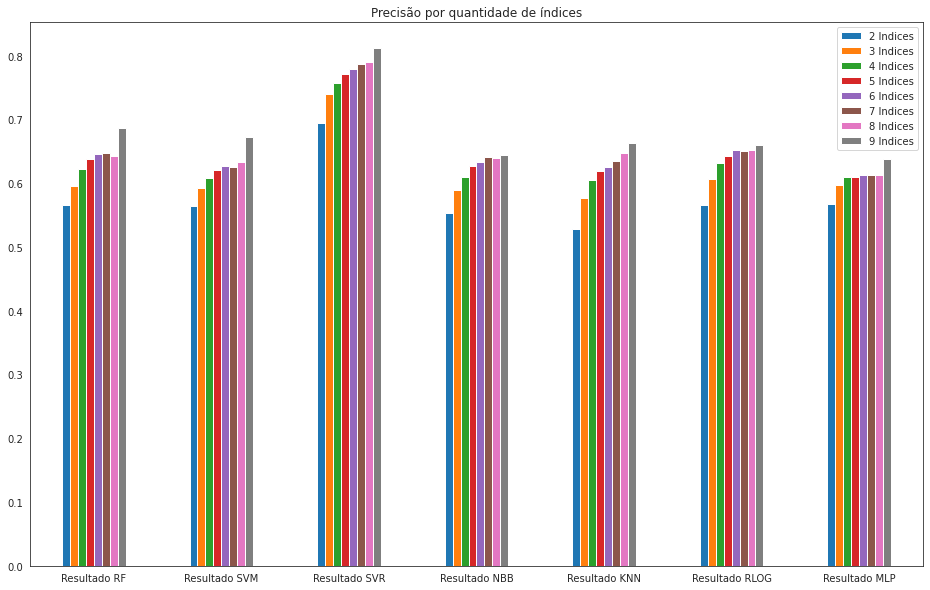

In [ ]:
plt.figure(figsize=(12,3))
b.plot(kind = 'bar', figsize=(16,10), rot=0, title='Precisão por quantidade de índices')

###Comb9

In [ ]:
(comb9.drop(['Sentimento', 'Ano', 'Tipo'], axis=1).mean()*100).round(2)

Resultado RF      68.59
Resultado SVM     67.22
Resultado SVR     81.17
Resultado NBB     64.43
Resultado KNN     66.32
Resultado RLOG    65.92
Resultado MLP     63.73
dtype: float64

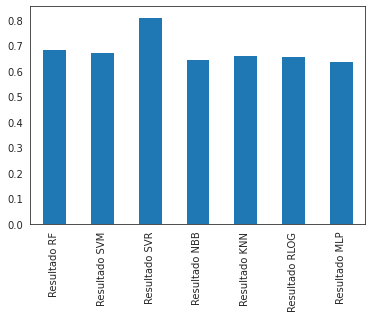

In [ ]:
comb9.drop(['Sentimento', 'Ano', 'Tipo'], axis=1).mean().plot.bar()

In [ ]:
comb9.drop(['Tipo', 'Sentimento'],axis=1).groupby(['Ano']).mean()

,Resultado RF,Resultado SVM,Resultado SVR,Resultado NBB,Resultado KNN,Resultado RLOG,Resultado MLP
Ano,,,,,,,
2014,0.653846,0.663462,0.817308,0.634615,0.644231,0.653846,0.615385
2015,0.670455,0.704545,0.829545,0.647727,0.670455,0.681818,0.625000
2016,0.694444,0.694444,0.805556,0.652778,0.652778,0.638889,0.625000
2017,0.683333,0.616667,0.833333,0.650000,0.666667,0.616667,0.616667
2018,0.727273,0.681818,0.772727,0.636364,0.681818,0.704545,0.704545


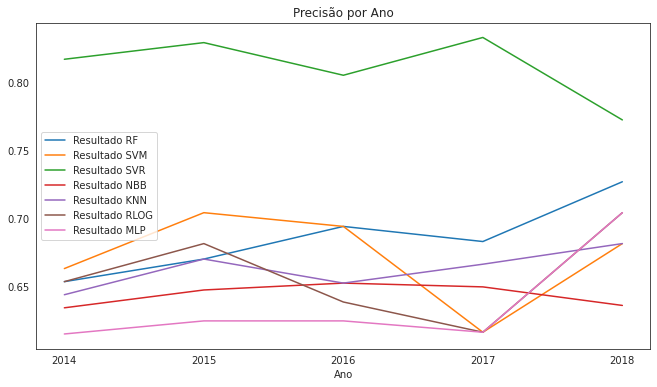

In [ ]:
comb9.drop(['Tipo', 'Sentimento'],axis=1).groupby(['Ano']).mean().plot(xticks=range(2014,2019), figsize=(11,6), title='Precisão por Ano')

In [ ]:
comb9.groupby(['Tipo', 'Ano', 'Sentimento']).mean()

Resultado RF  ...  Resultado MLP
Tipo Ano  Sentimento                ...               
2    2014 False           0.769231  ...       0.769231
          True            0.846154  ...       0.769231
     2015 False           0.772727  ...       0.727273
          True            0.818182  ...       0.772727
     2016 False           0.944444  ...       0.888889
          True            0.777778  ...       0.666667
     2017 False           0.866667  ...       0.800000
          True            0.866667  ...       0.933333
     2018 False           0.909091  ...       0.909091
          True            0.818182  ...       1.000000
N    2014 False           0.461538  ...       0.384615
          True            0.538462  ...       0.538462
     2015 False           0.454545  ...       0.545455
          True            0.636364  ...       0.454545
     2016 False           0.500000  ...       0.444444
          True            0.555556  ...       0.500000
     2017 False           0.466667  ...       0.266667
          True            0.533333  ...       0.466667
     2018 False           0.727273  ...       0.727273
          True            0.454545  ...       0.181818

[20 rows x 7 columns]

In [ ]:
comb9.drop(['Ano', 'Sentimento'],axis=1).groupby(['Tipo']).mean()

,Resultado RF,Resultado SVM,Resultado SVR,Resultado NBB,Resultado KNN,Resultado RLOG,Resultado MLP
Tipo,,,,,,,
2,0.838912,0.848718,0.815167,0.862362,0.859130,0.829814,0.823644
N,0.532828,0.495657,0.808221,0.426232,0.467249,0.488493,0.450995


In [ ]:
(comb9.drop(['Ano'],axis=1).groupby(['Tipo', 'Sentimento']).mean()*100).round(2)

Resultado RF  Resultado SVM  ...  Resultado RLOG  Resultado MLP
Tipo Sentimento                               ...                               
2    False              85.24          84.28  ...           83.91          81.89
     True               82.54          85.47  ...           82.05          82.84
N    False              52.20          48.40  ...           49.69          47.37
     True               54.37          50.73  ...           48.00          42.83

[4 rows x 7 columns]

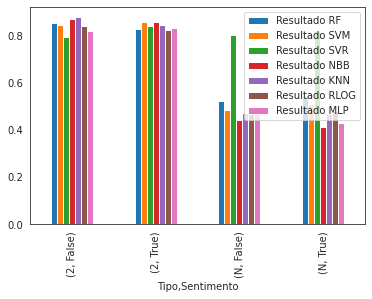

In [ ]:
comb9.drop(['Ano'],axis=1).groupby(['Tipo', 'Sentimento']).mean().plot(kind="bar")

###Comb8

In [ ]:
(comb8.drop(['Sentimento', 'Ano', 'Tipo'], axis=1).mean() * 100).round(2)

Resultado RF      64.23
Resultado SVM     63.35
Resultado SVR     78.99
Resultado NBB     63.99
Resultado KNN     64.71
Resultado RLOG    65.14
Resultado MLP     61.25
dtype: float64

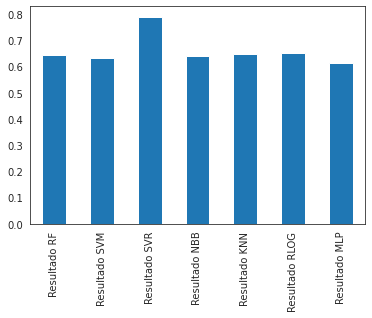

In [ ]:
comb8.drop(['Sentimento', 'Ano', 'Tipo'], axis=1).mean().plot.bar()

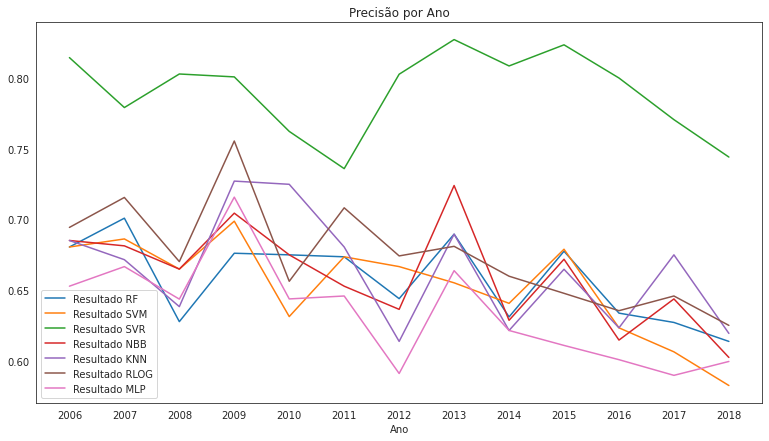

In [ ]:
comb8.drop(['Tipo', 'Sentimento'],axis=1).groupby(['Ano']).mean().plot(xticks=range(2006,2019), figsize=(13,7), title='Precisão por Ano')

In [ ]:
comb8.groupby(['Tipo', 'Ano', 'Sentimento']).mean()

In [ ]:
comb8.drop(['Ano', 'Sentimento'],axis=1).groupby(['Tipo']).mean()

,Resultado RF,Resultado SVM,Resultado SVR,Resultado NBB,Resultado KNN,Resultado RLOG,Resultado MLP
Tipo,,,,,,,
2,0.802301,0.791406,0.780162,0.830551,0.812581,0.811512,0.781628
N,0.482336,0.475649,0.799581,0.449156,0.481634,0.491261,0.443308


In [ ]:
(comb8.drop(['Ano'],axis=1).groupby(['Tipo', 'Sentimento']).mean() * 100).round(2)

Resultado RF  Resultado SVM  ...  Resultado RLOG  Resultado MLP
Tipo Sentimento                               ...                               
2    False              79.31          79.43  ...           80.20          78.22
     True               81.15          78.85  ...           82.10          78.10
N    False              48.18          46.94  ...           49.58          44.27
     True               48.29          48.19  ...           48.67          44.39

[4 rows x 7 columns]

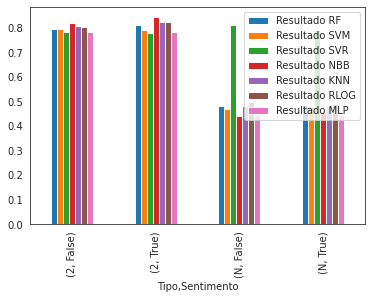

In [ ]:
comb8.drop(['Ano'],axis=1).groupby(['Tipo', 'Sentimento']).mean().plot(kind="bar")

###Comb7

In [ ]:
(comb7.drop(['Sentimento', 'Ano', 'Tipo'], axis=1).mean()*100).round(2)

Resultado RF      64.74
Resultado SVM     62.53
Resultado SVR     78.72
Resultado NBB     64.05
Resultado KNN     63.54
Resultado RLOG    65.04
Resultado MLP     61.34
dtype: float64

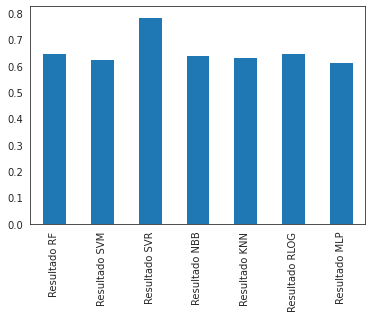

In [ ]:
comb7.drop(['Sentimento', 'Ano', 'Tipo'], axis=1).mean().plot.bar()

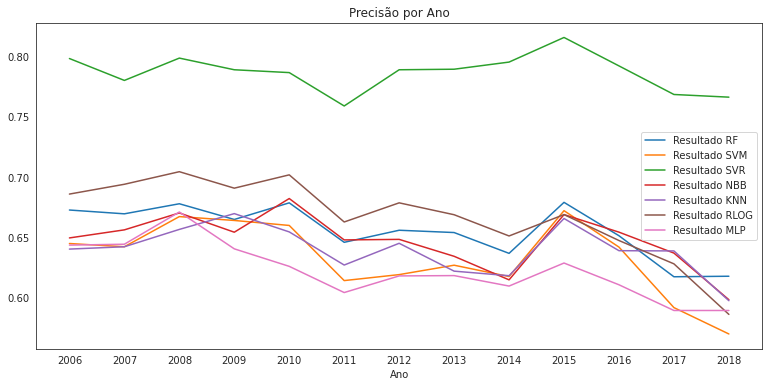

In [ ]:
comb7.drop(['Tipo', 'Sentimento'],axis=1).groupby(['Ano']).mean().plot(xticks=range(2006,2019), figsize=(13,6), title='Precisão por Ano')

In [ ]:
comb7.groupby(['Tipo', 'Ano', 'Sentimento']).mean()

In [ ]:
comb7.drop(['Ano', 'Sentimento'],axis=1).groupby(['Tipo']).mean()

,Resultado RF,Resultado SVM,Resultado SVR,Resultado NBB,Resultado KNN,Resultado RLOG,Resultado MLP
Tipo,,,,,,,
2,0.803841,0.783612,0.783349,0.821266,0.801086,0.801720,0.774303
N,0.490906,0.467057,0.791051,0.459747,0.469752,0.499124,0.452480


In [ ]:
(comb7.drop(['Ano'],axis=1).groupby(['Tipo', 'Sentimento']).mean() * 100 ).round(2)

Resultado RF  Resultado SVM  ...  Resultado RLOG  Resultado MLP
Tipo Sentimento                               ...                               
2    False              80.47          78.71  ...           80.31          78.30
     True               80.30          78.01  ...           80.04          76.56
N    False              50.39          47.60  ...           50.71          44.27
     True               47.80          45.81  ...           49.11          46.22

[4 rows x 7 columns]

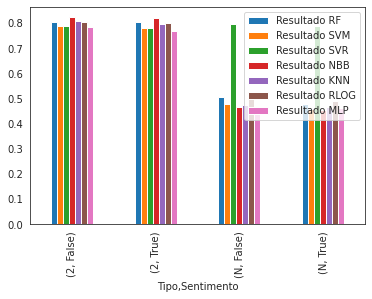

In [ ]:
comb7.drop(['Ano'],axis=1).groupby(['Tipo', 'Sentimento']).mean().plot(kind="bar")

###Comb6

In [ ]:
(comb6.drop(['Sentimento', 'Ano', 'Tipo'], axis=1).mean()*100).round(2)

Resultado RF      64.49
Resultado SVM     62.62
Resultado SVR     77.97
Resultado NBB     63.39
Resultado KNN     62.58
Resultado RLOG    65.15
Resultado MLP     61.27
dtype: float64

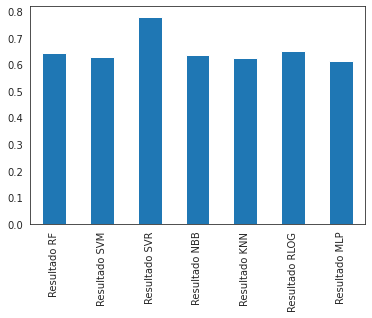

In [ ]:
comb6.drop(['Sentimento', 'Ano', 'Tipo'], axis=1).mean().plot.bar()

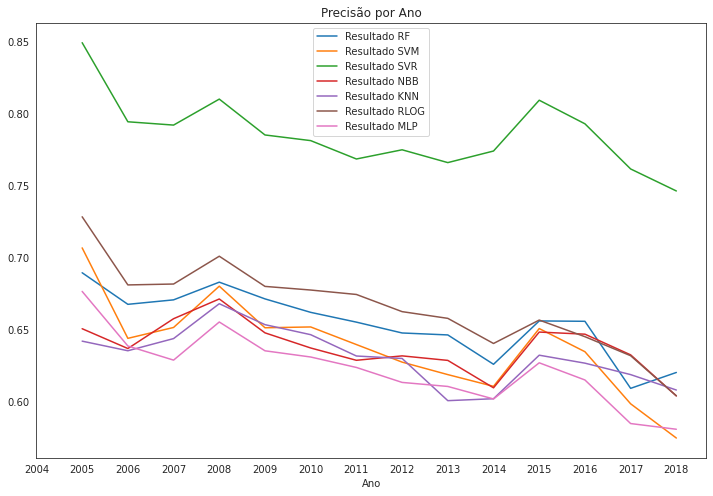

In [ ]:
comb6.drop(['Tipo', 'Sentimento'],axis=1).groupby(['Ano']).mean().plot(xticks=range(2004,2019), figsize=(12,8), title='Precisão por Ano')

In [ ]:
comb6.groupby(['Tipo', 'Ano', 'Sentimento']).mean()

In [ ]:
comb6.drop(['Ano', 'Sentimento'],axis=1).groupby(['Tipo']).mean()

,Resultado RF,Resultado SVM,Resultado SVR,Resultado NBB,Resultado KNN,Resultado RLOG,Resultado MLP
Tipo,,,,,,,
2,0.797628,0.778436,0.778230,0.811970,0.786825,0.800354,0.775020
N,0.492081,0.473958,0.781138,0.455785,0.464748,0.502686,0.450404


In [ ]:
(comb6.drop(['Ano'],axis=1).groupby(['Tipo', 'Sentimento']).mean()*100).round(2)

Resultado RF  Resultado SVM  ...  Resultado RLOG  Resultado MLP
Tipo Sentimento                               ...                               
2    False              79.41          77.72  ...           79.79          77.96
     True               80.11          77.97  ...           80.28          77.04
N    False              49.60          47.44  ...           50.35          44.68
     True               48.82          47.35  ...           50.18          45.40

[4 rows x 7 columns]

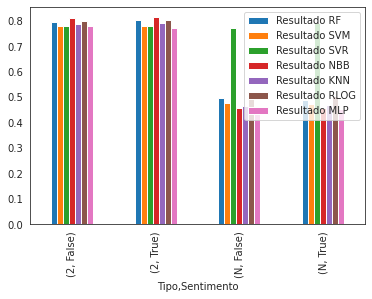

In [ ]:
comb6.drop(['Ano'],axis=1).groupby(['Tipo', 'Sentimento']).mean().plot(kind="bar")

###Comb5

In [ ]:
(comb5.drop(['Sentimento', 'Ano', 'Tipo'], axis=1).mean()*100).round(2)

Resultado RF      63.77
Resultado SVM     62.00
Resultado SVR     77.03
Resultado NBB     62.66
Resultado KNN     61.84
Resultado RLOG    64.24
Resultado MLP     61.01
dtype: float64

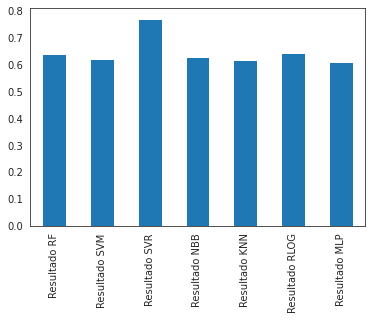

In [ ]:
comb5.drop(['Sentimento', 'Ano', 'Tipo'], axis=1).mean().plot.bar()

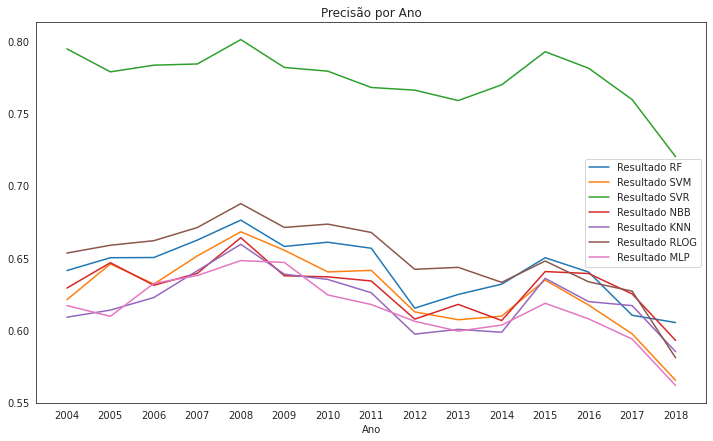

In [ ]:
comb5.drop(['Tipo', 'Sentimento'],axis=1).groupby(['Ano']).mean().plot(xticks=range(2004,2019), figsize=(12,7), title='Precisão por Ano')

In [ ]:
comb5.groupby(['Tipo', 'Ano', 'Sentimento']).mean()

In [ ]:
comb5.drop(['Ano', 'Sentimento'],axis=1).groupby(['Tipo']).mean()

,Resultado RF,Resultado SVM,Resultado SVR,Resultado NBB,Resultado KNN,Resultado RLOG,Resultado MLP
Tipo,,,,,,,
2,0.787207,0.771848,0.768556,0.800914,0.776981,0.792620,0.770200
N,0.488290,0.468060,0.772101,0.452237,0.459754,0.492176,0.450072


In [ ]:
(comb5.drop(['Ano'],axis=1).groupby(['Tipo', 'Sentimento']).mean()*100).round(2)

Resultado RF  Resultado SVM  ...  Resultado RLOG  Resultado MLP
Tipo Sentimento                               ...                               
2    False              78.61          77.54  ...           79.23          77.57
     True               78.83          76.83  ...           79.29          76.47
N    False              49.24          46.90  ...           49.54          45.03
     True               48.42          46.71  ...           48.90          44.98

[4 rows x 7 columns]

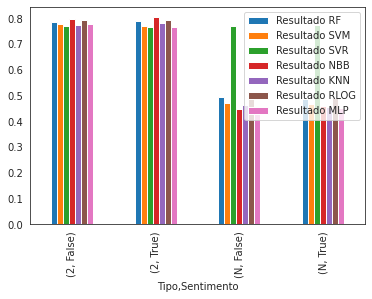

In [ ]:
comb5.drop(['Ano'],axis=1).groupby(['Tipo', 'Sentimento']).mean().plot(kind="bar")

###Comb4

In [ ]:
(comb4.drop(['Sentimento', 'Ano', 'Tipo'], axis=1).mean()*100).round(2)

Resultado RF      62.20
Resultado SVM     60.87
Resultado SVR     75.66
Resultado NBB     61.01
Resultado KNN     60.45
Resultado RLOG    63.16
Resultado MLP     60.93
dtype: float64

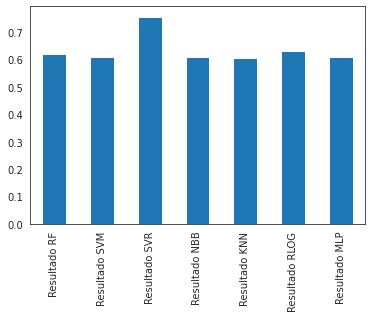

In [ ]:
comb4.drop(['Sentimento', 'Ano', 'Tipo'], axis=1).mean().plot.bar()

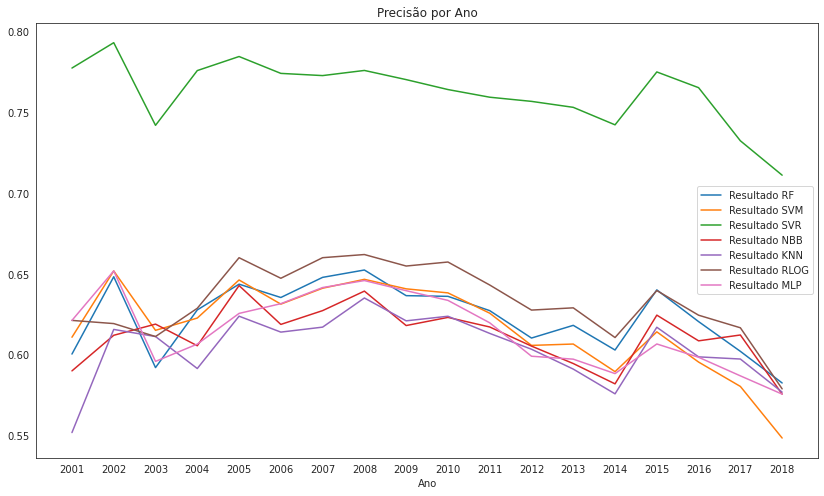

In [ ]:
comb4.drop(['Tipo', 'Sentimento'],axis=1).groupby(['Ano']).mean().plot(xticks=range(2001,2019), figsize=(14,8), title='Precisão por Ano')

In [ ]:
comb4.groupby(['Tipo', 'Ano', 'Sentimento']).mean()

In [ ]:
comb4.drop(['Ano', 'Sentimento'],axis=1).groupby(['Tipo']).mean()

,Resultado RF,Resultado SVM,Resultado SVR,Resultado NBB,Resultado KNN,Resultado RLOG,Resultado MLP
Tipo,,,,,,,
2,0.769330,0.759027,0.757950,0.780869,0.754832,0.775252,0.763157
N,0.474688,0.458411,0.755215,0.439326,0.454100,0.487928,0.455364


In [ ]:
(comb4.drop(['Ano'],axis=1).groupby(['Tipo', 'Sentimento']).mean()*100).round(2)

Resultado RF  Resultado SVM  ...  Resultado RLOG  Resultado MLP
Tipo Sentimento                               ...                               
2    False              76.56          75.62  ...           77.33          76.14
     True               77.31          76.19  ...           77.72          76.49
N    False              46.87          45.80  ...           48.74          45.60
     True               48.06          45.88  ...           48.85          45.47

[4 rows x 7 columns]

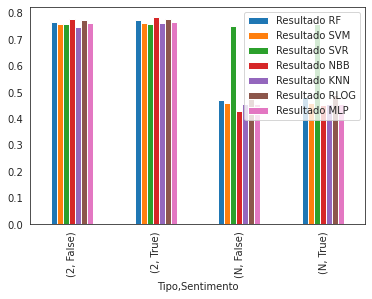

In [ ]:
comb4.drop(['Ano'],axis=1).groupby(['Tipo', 'Sentimento']).mean().plot(kind="bar")

###Comb3

In [ ]:
(comb3.drop(['Sentimento', 'Ano', 'Tipo'], axis=1).mean()*100).round(2)

Resultado RF      59.59
Resultado SVM     59.29
Resultado SVR     73.93
Resultado NBB     58.87
Resultado KNN     57.69
Resultado RLOG    60.61
Resultado MLP     59.63
dtype: float64

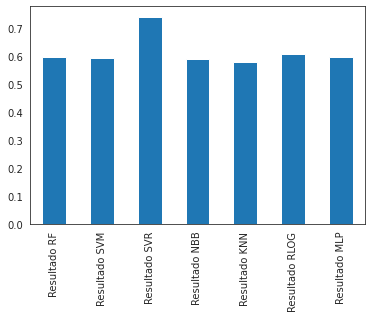

In [ ]:
comb3.drop(['Sentimento', 'Ano', 'Tipo'], axis=1).mean().plot.bar()

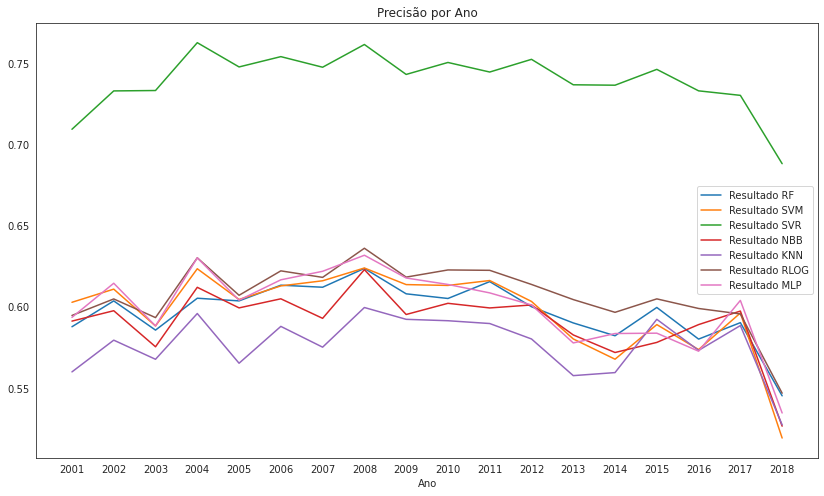

In [ ]:
comb3.drop(['Tipo', 'Sentimento'],axis=1).groupby(['Ano']).mean().plot(xticks=range(2001,2019), figsize=(14,8), title='Precisão por Ano')

In [ ]:
comb3.groupby(['Tipo', 'Ano', 'Sentimento']).mean()

Resultado RF  ...  Resultado MLP
Tipo Ano  Sentimento                ...               
2    2001 False           0.712963  ...       0.712963
          True            0.680556  ...       0.685185
     2002 False           0.748792  ...       0.748792
          True            0.724638  ...       0.714976
     2003 False           0.717949  ...       0.717949
...                            ...  ...            ...
N    2016 True            0.414683  ...       0.402778
     2017 False           0.416667  ...       0.464286
          True            0.454762  ...       0.442857
     2018 False           0.402597  ...       0.392857
          True            0.373377  ...       0.353896

[72 rows x 7 columns]

In [ ]:
comb3.drop(['Ano', 'Sentimento'],axis=1).groupby(['Tipo']).mean()

,Resultado RF,Resultado SVM,Resultado SVR,Resultado NBB,Resultado KNN,Resultado RLOG,Resultado MLP
Tipo,,,,,,,
2,0.739508,0.736587,0.734824,0.744240,0.720933,0.744691,0.738348
N,0.452239,0.449119,0.743711,0.433088,0.432964,0.467472,0.454213


In [ ]:
(comb3.drop(['Ano'],axis=1).groupby(['Tipo', 'Sentimento']).mean()*100).round(2)

Resultado RF  Resultado SVM  ...  Resultado RLOG  Resultado MLP
Tipo Sentimento                               ...                               
2    False              73.43          73.31  ...           73.67          73.39
     True               74.47          74.01  ...           75.27          74.28
N    False              45.56          45.46  ...           46.88          46.30
     True               44.89          44.37  ...           46.62          44.55

[4 rows x 7 columns]

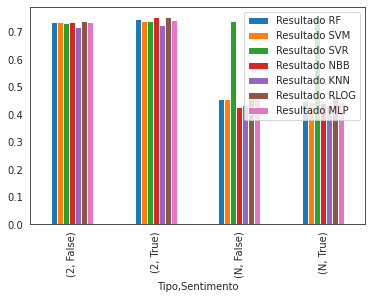

In [ ]:
comb3.drop(['Ano'],axis=1).groupby(['Tipo', 'Sentimento']).mean().plot(kind="bar")

###Comb2

In [ ]:
(comb2.drop(['Sentimento', 'Ano', 'Tipo'], axis=1).mean()*100).round(2)

Resultado RF      56.55
Resultado SVM     56.37
Resultado SVR     69.45
Resultado NBB     55.31
Resultado KNN     52.84
Resultado RLOG    56.53
Resultado MLP     56.77
dtype: float64

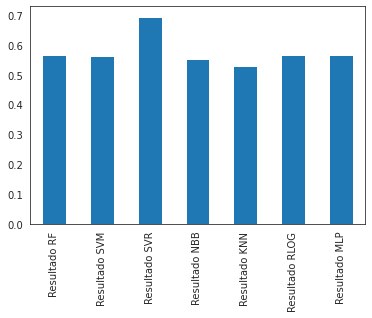

In [ ]:
comb2.drop(['Sentimento', 'Ano', 'Tipo'], axis=1).mean().plot.bar()

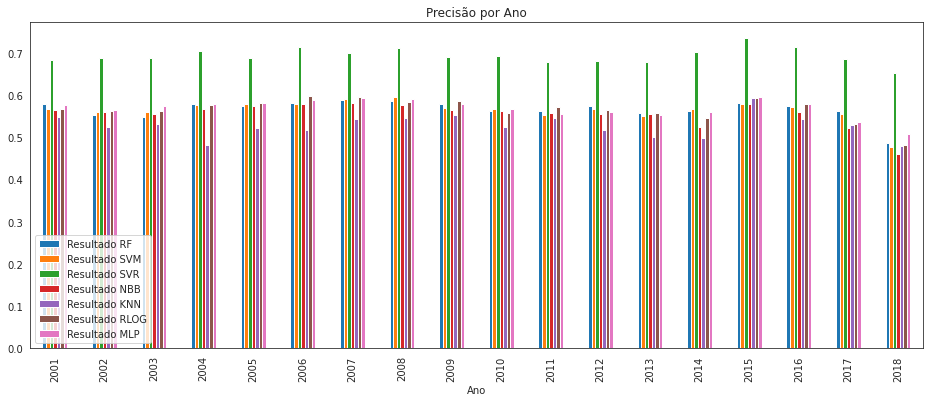

In [ ]:
comb2.drop(['Tipo', 'Sentimento'],axis=1).groupby(['Ano']).mean().plot(figsize=(16,6), title='Precisão por Ano', kind='bar').legend(loc='lower left')

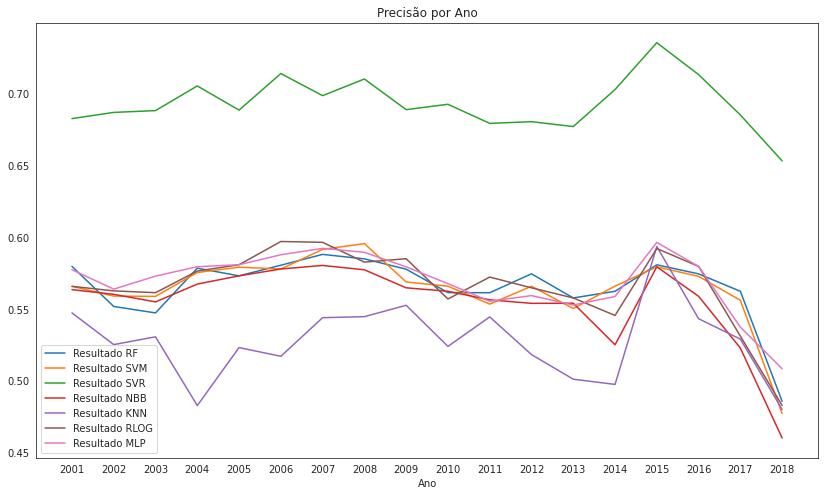

In [ ]:
comb2.drop(['Tipo', 'Sentimento'],axis=1).groupby(['Ano']).mean().plot(xticks=range(2001,2019), figsize=(14,8), title='Precisão por Ano')

In [ ]:
comb2.drop(['Tipo', 'Sentimento'],axis=1).groupby(['Ano']).mean()

,Resultado RF,Resultado SVM,Resultado SVR,Resultado NBB,Resultado KNN,Resultado RLOG,Resultado MLP
Ano,,,,,,,
2001,0.579861,0.565972,0.682870,0.563657,0.547454,0.565972,0.577546
2002,0.551932,0.559179,0.687198,0.560386,0.525362,0.562802,0.564010
2003,0.547436,0.558974,0.688462,0.555128,0.530769,0.561538,0.573077
2004,0.578629,0.575605,0.705645,0.567540,0.482863,0.576613,0.579637
2005,0.573276,0.579310,0.688793,0.573276,0.523276,0.581034,0.581034
2006,0.580688,0.578042,0.714286,0.578042,0.517196,0.597222,0.587963
2007,0.588235,0.591737,0.698880,0.580532,0.544118,0.596639,0.592437
2008,0.585106,0.595745,0.710486,0.577508,0.544833,0.582827,0.589666
2009,0.577922,0.568994,0.689123,0.564935,0.552760,0.585227,0.579545


In [ ]:
comb2.groupby(['Tipo', 'Ano', 'Sentimento']).mean()

Resultado RF  ...  Resultado MLP
Tipo Ano  Sentimento                ...               
2    2001 False           0.680556  ...       0.680556
          True            0.662037  ...       0.662037
     2002 False           0.657005  ...       0.657005
          True            0.666667  ...       0.666667
     2003 False           0.702564  ...       0.702564
...                            ...  ...            ...
N    2016 True            0.381944  ...       0.402778
     2017 False           0.400000  ...       0.408333
          True            0.391667  ...       0.383333
     2018 False           0.306818  ...       0.340909
          True            0.329545  ...       0.386364

[72 rows x 7 columns]

In [ ]:
(comb2.drop(['Ano', 'Sentimento'],axis=1).groupby(['Tipo']).mean()*100).round(2)

,Resultado RF,Resultado SVM,Resultado SVR,Resultado NBB,Resultado KNN,Resultado RLOG,Resultado MLP
Tipo,,,,,,,
2,69.85,69.40,69.22,69.27,65.77,68.87,69.19
N,43.24,43.35,69.68,41.34,39.91,44.18,44.35


In [ ]:
(comb2.drop(['Ano'],axis=1).groupby(['Tipo', 'Sentimento']).mean()*100).round(2)

Resultado RF  Resultado SVM  ...  Resultado RLOG  Resultado MLP
Tipo Sentimento                               ...                               
2    False              70.05          69.71  ...           69.44          69.71
     True               69.66          69.08  ...           68.30          68.66
N    False              43.83          43.83  ...           44.22          44.23
     True               42.65          42.86  ...           44.14          44.47

[4 rows x 7 columns]

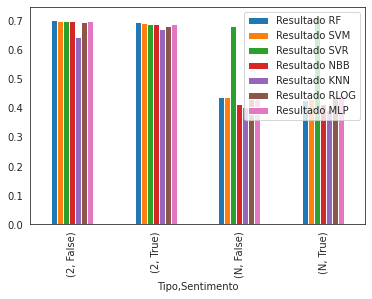

In [ ]:
comb2.drop(['Ano'],axis=1).groupby(['Tipo', 'Sentimento']).mean().plot(kind="bar")

### Comb geral

In [ ]:
comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().iloc[0]

Resultado RF      0.600694
Resultado SVM     0.611111
Resultado SVR     0.777778
Resultado NBB     0.590278
Resultado KNN     0.552083
Resultado RLOG    0.621528
Resultado MLP     0.621528
Name: 2001, dtype: float64

#### 2001

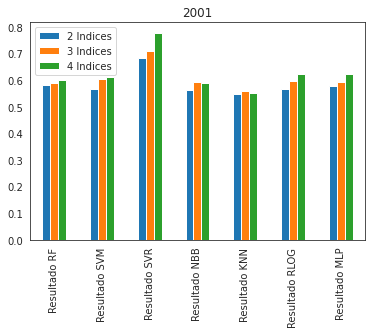

In [ ]:
colunas_dropadas = ['Sentimento', 'Ano', 'Tipo', 'Indices']
indice = comb9.drop(colunas_dropadas, axis=1).columns
ano = 2001
b = pd.DataFrame(
    {'2 Indices': comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '3 Indices': comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '4 Indices': comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano]     
     }, index=indice
)
b.plot(kind='bar', title=ano)

In [ ]:
ano = 2001
c = pd.Series(
    {'2 Indices': round((comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '3 Indices': round((comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '4 Indices': round((comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2)     
    }
)
c.sort_values(ascending=False)

4 Indices    62.50
3 Indices    60.58
2 Indices    58.33
dtype: float64

#### 2002

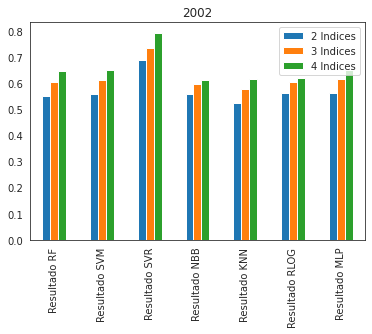

In [ ]:
colunas_dropadas = ['Sentimento', 'Ano', 'Tipo', 'Indices']
indice = comb9.drop(colunas_dropadas, axis=1).columns
ano = 2002

b = pd.DataFrame(
    {'2 Indices': comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '3 Indices': comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '4 Indices': comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano]     
     }, index=indice
)
b.plot(kind='bar', title=ano)

In [ ]:
ano = 2002
c = pd.Series(
    {'2 Indices': round((comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '3 Indices': round((comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '4 Indices': round((comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2)     
    }
)
c.sort_values(ascending=False)

4 Indices    65.63
3 Indices    62.08
2 Indices    57.30
dtype: float64

#### 2003

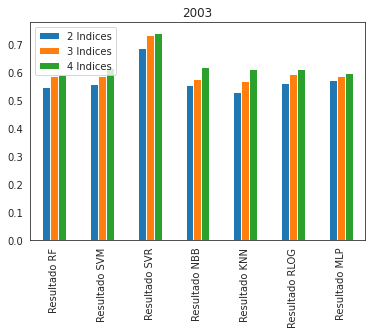

In [ ]:
colunas_dropadas = ['Sentimento', 'Ano', 'Tipo', 'Indices']
indice = comb9.drop(colunas_dropadas, axis=1).columns
ano = 2003

b = pd.DataFrame(
    {'2 Indices': comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '3 Indices': comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '4 Indices': comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano]     
     }, index=indice
)
b.plot(kind='bar', title=ano)

In [ ]:
ano = 2003
c = pd.Series(
    {'2 Indices': round((comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '3 Indices': round((comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '4 Indices': round((comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2)     
    }
)
c.sort_values(ascending=False)

4 Indices    62.69
3 Indices    60.48
2 Indices    57.36
dtype: float64

#### 2004

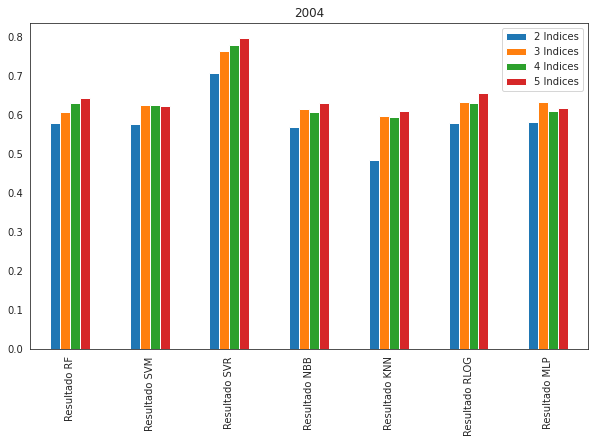

In [ ]:
colunas_dropadas = ['Sentimento', 'Ano', 'Tipo', 'Indices']
indice = comb9.drop(colunas_dropadas, axis=1).columns
ano = 2004
b = pd.DataFrame(
    {'2 Indices': comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '3 Indices': comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '4 Indices': comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '5 Indices': comb5.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano]     
     }, index=indice
)
b.plot(kind='bar', title=ano, figsize=(10,6))

In [ ]:
(b * 100).round(2)

,2 Indices,3 Indices,4 Indices,5 Indices
Resultado RF,57.86,60.55,62.80,64.11
Resultado SVM,57.56,62.37,62.30,62.10
Resultado SVR,70.56,76.28,77.62,79.44
Resultado NBB,56.75,61.22,60.58,62.90
Resultado KNN,48.29,59.61,59.17,60.89
Resultado RLOG,57.66,63.04,62.90,65.32
Resultado MLP,57.96,63.04,60.69,61.69


In [ ]:
ano = 2004
c = pd.Series(
    {'2 Indices': round((comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '3 Indices': round((comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '4 Indices': round((comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '5 Indices': round((comb5.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2)     
     
    }
)
c.sort_values(ascending=False)

5 Indices    65.21
3 Indices    63.73
4 Indices    63.72
2 Indices    58.09
dtype: float64

#### 2005

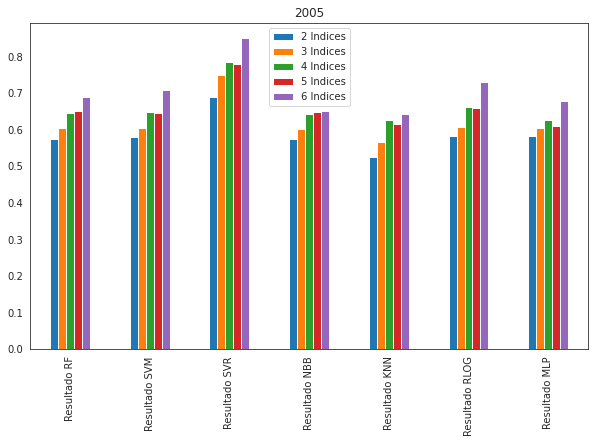

In [ ]:
colunas_dropadas = ['Sentimento', 'Ano', 'Tipo', 'Indices']
indice = comb9.drop(colunas_dropadas, axis=1).columns
ano = 2005
b = pd.DataFrame(
    {'2 Indices': comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '3 Indices': comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '4 Indices': comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '5 Indices': comb5.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '6 Indices': comb6.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano]     
     }, index=indice
)
b.plot(kind='bar', title=ano, figsize=(10,6))

In [ ]:
(b * 100).round(2)

,2 Indices,3 Indices,4 Indices,5 Indices,6 Indices
Resultado RF,57.33,60.39,64.40,65.00,68.97
Resultado SVM,57.93,60.47,64.66,64.57,70.69
Resultado SVR,68.88,74.78,78.49,77.84,84.91
Resultado NBB,57.33,59.96,64.31,64.66,65.09
Resultado KNN,52.33,56.55,62.41,61.38,64.22
Resultado RLOG,58.10,60.73,66.03,65.86,72.84
Resultado MLP,58.10,60.43,62.59,60.95,67.67


In [ ]:
ano = 2005
c = pd.Series(
    {'2 Indices': round((comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '3 Indices': round((comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '4 Indices': round((comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '5 Indices': round((comb5.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '6 Indices': round((comb6.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2)     
     
    }
)
c.sort_values(ascending=False)

6 Indices    70.63
4 Indices    66.13
5 Indices    65.75
3 Indices    61.90
2 Indices    58.57
dtype: float64

#### 2006

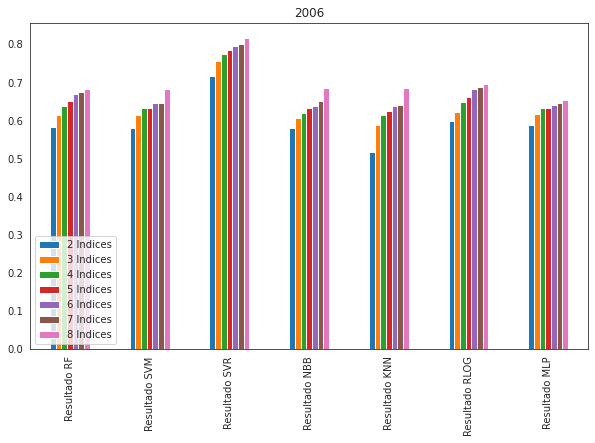

In [ ]:
colunas_dropadas = ['Sentimento', 'Ano', 'Tipo', 'Indices']
indice = comb9.drop(colunas_dropadas, axis=1).columns
ano = 2006
b = pd.DataFrame(
    {'2 Indices': comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '3 Indices': comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '4 Indices': comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '5 Indices': comb5.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '6 Indices': comb6.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '7 Indices': comb7.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],     
     '8 Indices': comb8.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano]     
     
     }, index=indice
)
b.plot(kind='bar', title=ano, figsize=(10,6)).legend(loc='lower left')

In [ ]:
(b * 100).round(2)

,2 Indices,3 Indices,4 Indices,5 Indices,6 Indices,7 Indices,8 Indices
Resultado RF,58.07,61.35,63.57,65.01,66.78,67.26,68.06
Resultado SVM,57.80,61.31,63.16,63.17,64.42,64.48,68.06
Resultado SVR,71.43,75.42,77.45,78.31,79.43,79.83,81.48
Resultado NBB,57.80,60.52,61.90,63.10,63.71,64.95,68.52
Resultado KNN,51.72,58.82,61.43,62.25,63.56,64.02,68.52
Resultado RLOG,59.72,62.24,64.76,66.18,68.12,68.58,69.44
Resultado MLP,58.80,61.68,63.19,63.23,63.89,64.35,65.28


In [ ]:
ano = 2006
c = pd.Series(
    {'2 Indices': round((comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '3 Indices': round((comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '4 Indices': round((comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '5 Indices': round((comb5.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '6 Indices': round((comb6.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '7 Indices': round((comb7.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '8 Indices': round((comb8.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2)     
     
    }
)
c.sort_values(ascending=False)

8 Indices    69.91
7 Indices    67.64
6 Indices    67.13
5 Indices    65.89
4 Indices    65.07
3 Indices    63.05
2 Indices    59.33
dtype: float64

#### 2007

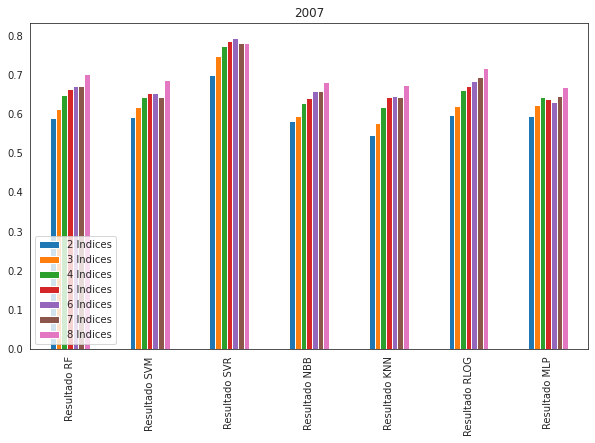

In [ ]:
colunas_dropadas = ['Sentimento', 'Ano', 'Tipo', 'Indices']
indice = comb9.drop(colunas_dropadas, axis=1).columns
ano = 2007
b = pd.DataFrame(
    {'2 Indices': comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '3 Indices': comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '4 Indices': comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '5 Indices': comb5.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '6 Indices': comb6.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '7 Indices': comb7.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],     
     '8 Indices': comb8.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano]     
     
     }, index=indice
)
b.plot(kind='bar', title=ano, figsize=(10,6)).legend(loc='lower left')

In [ ]:
(b * 100).round(2)

,2 Indices,3 Indices,4 Indices,5 Indices,6 Indices,7 Indices,8 Indices
Resultado RF,58.82,61.23,64.82,66.22,67.09,66.95,70.10
Resultado SVM,59.17,61.62,64.15,65.13,65.17,64.22,68.63
Resultado SVR,69.89,74.77,77.31,78.39,79.20,78.01,77.94
Resultado NBB,58.05,59.31,62.76,63.92,65.78,65.62,68.14
Resultado KNN,54.41,57.54,61.74,64.10,64.40,64.22,67.16
Resultado RLOG,59.66,61.83,66.04,67.09,68.18,69.40,71.57
Resultado MLP,59.24,62.21,64.19,63.77,62.91,64.43,66.67


In [ ]:
ano = 2007
c = pd.Series(
    {'2 Indices': round((comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '3 Indices': round((comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '4 Indices': round((comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '5 Indices': round((comb5.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '6 Indices': round((comb6.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '7 Indices': round((comb7.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '8 Indices': round((comb8.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2)     
     
    }
)
c.sort_values(ascending=False)

8 Indices    70.03
7 Indices    67.55
6 Indices    67.53
5 Indices    66.94
4 Indices    65.86
3 Indices    62.65
2 Indices    59.89
dtype: float64

#### 2008

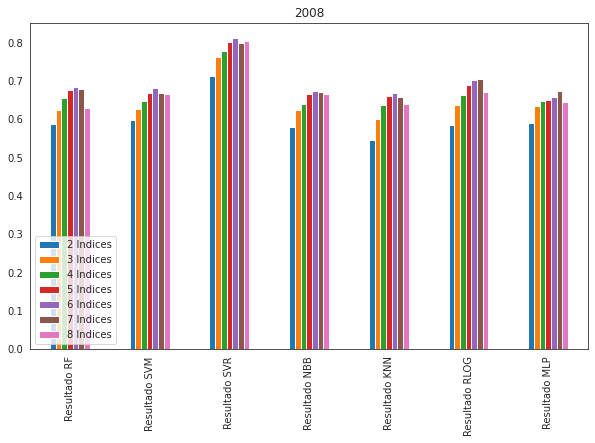

In [ ]:
colunas_dropadas = ['Sentimento', 'Ano', 'Tipo', 'Indices']
indice = comb9.drop(colunas_dropadas, axis=1).columns
ano = 2008
b = pd.DataFrame(
    {'2 Indices': comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '3 Indices': comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '4 Indices': comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '5 Indices': comb5.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '6 Indices': comb6.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '7 Indices': comb7.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],     
     '8 Indices': comb8.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano]     
     
     }, index=indice
)
b.plot(kind='bar', title=ano, figsize=(10,6)).legend(loc='lower left')

In [ ]:
(b * 100).round(2)

,2 Indices,3 Indices,4 Indices,5 Indices,6 Indices,7 Indices,8 Indices
Resultado RF,58.51,62.39,65.27,67.60,68.31,67.78,62.77
Resultado SVM,59.57,62.41,64.70,66.79,68.03,66.72,66.49
Resultado SVR,71.05,76.17,77.63,80.08,81.00,79.86,80.32
Resultado NBB,57.75,62.31,63.97,66.38,67.15,67.02,66.49
Resultado KNN,54.48,59.98,63.54,65.93,66.82,65.65,63.83
Resultado RLOG,58.28,63.63,66.23,68.74,70.11,70.44,67.02
Resultado MLP,58.97,63.20,64.62,64.80,65.55,67.10,64.36


In [ ]:
ano = 2008
c = pd.Series(
    {'2 Indices': round((comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '3 Indices': round((comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '4 Indices': round((comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '5 Indices': round((comb5.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '6 Indices': round((comb6.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '7 Indices': round((comb7.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '8 Indices': round((comb8.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2)     
     
    }
)
c.sort_values(ascending=False)

6 Indices    69.57
7 Indices    69.22
5 Indices    68.62
8 Indices    67.33
4 Indices    66.57
3 Indices    64.30
2 Indices    59.80
dtype: float64

#### 2009

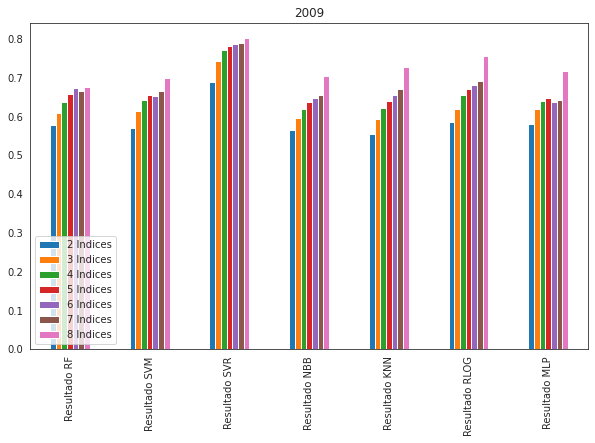

In [ ]:
colunas_dropadas = ['Sentimento', 'Ano', 'Tipo', 'Indices']
indice = comb9.drop(colunas_dropadas, axis=1).columns
ano = 2009
b = pd.DataFrame(
    {'2 Indices': comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '3 Indices': comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '4 Indices': comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '5 Indices': comb5.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '6 Indices': comb6.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '7 Indices': comb7.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],     
     '8 Indices': comb8.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano]     
     
     }, index=indice
)
b.plot(kind='bar', title=ano, figsize=(10,6)).legend(loc='lower left')

In [ ]:
(b * 100).round(2)

,2 Indices,3 Indices,4 Indices,5 Indices,6 Indices,7 Indices,8 Indices
Resultado RF,57.79,60.82,63.69,65.78,67.15,66.48,67.61
Resultado SVM,56.90,61.39,64.11,65.52,65.15,66.40,69.89
Resultado SVR,68.91,74.32,77.06,78.15,78.52,78.90,80.11
Resultado NBB,56.49,59.55,61.83,63.75,64.80,65.42,70.45
Resultado KNN,55.28,59.25,62.13,63.86,65.37,66.96,72.73
Resultado RLOG,58.52,61.85,65.52,67.09,68.02,69.07,75.57
Resultado MLP,57.95,61.80,63.99,64.68,63.56,64.04,71.59


In [ ]:
ano = 2009
c = pd.Series(
    {'2 Indices': round((comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '3 Indices': round((comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '4 Indices': round((comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '5 Indices': round((comb5.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '6 Indices': round((comb6.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '7 Indices': round((comb7.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '8 Indices': round((comb8.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2)     
     
    }
)
c.sort_values(ascending=False)

8 Indices    72.56
7 Indices    68.18
6 Indices    67.51
5 Indices    66.98
4 Indices    65.48
3 Indices    62.71
2 Indices    58.84
dtype: float64

#### 2010

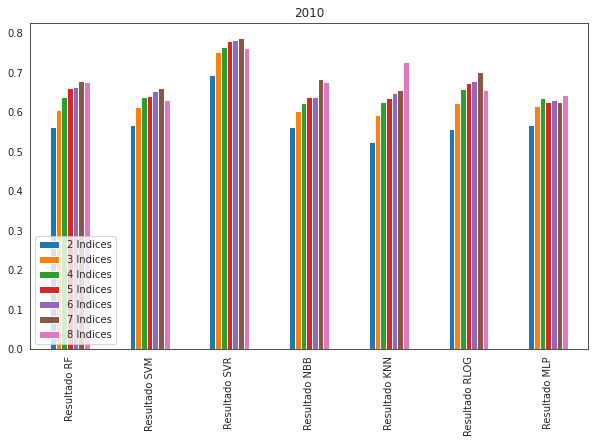

In [ ]:
colunas_dropadas = ['Sentimento', 'Ano', 'Tipo', 'Indices']
indice = comb9.drop(colunas_dropadas, axis=1).columns
ano = 2010
b = pd.DataFrame(
    {'2 Indices': comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '3 Indices': comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '4 Indices': comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '5 Indices': comb5.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '6 Indices': comb6.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '7 Indices': comb7.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],     
     '8 Indices': comb8.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano]     
     
     }, index=indice
)
b.plot(kind='bar', title=ano, figsize=(10,6)).legend(loc='lower left')

In [ ]:
(b * 100).round(2)

,2 Indices,3 Indices,4 Indices,5 Indices,6 Indices,7 Indices,8 Indices
Resultado RF,56.16,60.54,63.64,66.07,66.22,67.86,67.50
Resultado SVM,56.61,61.34,63.86,64.02,65.21,65.98,63.12
Resultado SVR,69.29,75.06,76.45,77.89,78.13,78.66,76.25
Resultado NBB,56.25,60.24,62.34,63.68,63.75,68.21,67.50
Resultado KNN,52.41,59.17,62.41,63.50,64.67,65.45,72.50
Resultado RLOG,55.71,62.29,65.77,67.32,67.77,70.18,65.62
Resultado MLP,56.79,61.40,63.39,62.43,63.12,62.59,64.38


In [ ]:
ano = 2010
c = pd.Series(
    {'2 Indices': round((comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '3 Indices': round((comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '4 Indices': round((comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '5 Indices': round((comb5.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '6 Indices': round((comb6.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '7 Indices': round((comb7.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '8 Indices': round((comb8.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2)     
     
    }
)
c.sort_values(ascending=False)

7 Indices    68.42
8 Indices    68.12
6 Indices    66.98
5 Indices    66.42
4 Indices    65.41
3 Indices    62.86
2 Indices    57.60
dtype: float64

#### 2011

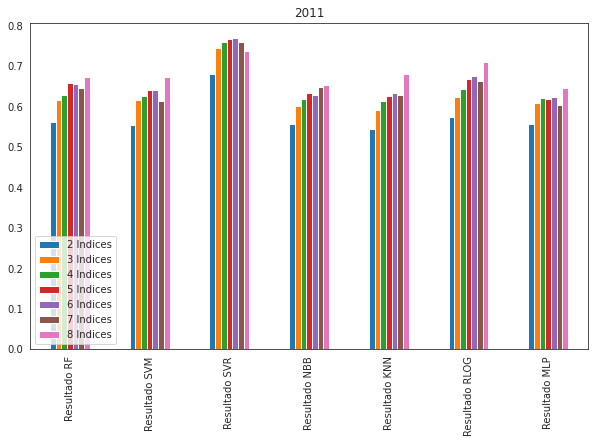

In [ ]:
colunas_dropadas = ['Sentimento', 'Ano', 'Tipo', 'Indices']
indice = comb9.drop(colunas_dropadas, axis=1).columns
ano = 2011
b = pd.DataFrame(
    {'2 Indices': comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '3 Indices': comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '4 Indices': comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '5 Indices': comb5.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '6 Indices': comb6.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '7 Indices': comb7.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],     
     '8 Indices': comb8.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano]     
     
     }, index=indice
)
b.plot(kind='bar', title=ano, figsize=(10,6)).legend(loc='lower left')

In [ ]:
(b * 100).round(2)

,2 Indices,3 Indices,4 Indices,5 Indices,6 Indices,7 Indices,8 Indices
Resultado RF,56.15,61.57,62.76,65.65,65.54,64.58,67.36
Resultado SVM,55.36,61.64,62.60,64.13,63.99,61.41,67.36
Resultado SVR,67.96,74.47,75.97,76.77,76.85,75.89,73.61
Resultado NBB,55.65,59.95,61.75,63.39,62.90,64.78,65.28
Resultado KNN,54.46,58.99,61.35,62.58,63.19,62.70,68.06
Resultado RLOG,57.24,62.27,64.35,66.75,67.46,66.27,70.83
Resultado MLP,55.56,60.88,62.00,61.77,62.40,60.42,64.58


In [ ]:
ano = 2011
c = pd.Series(
    {'2 Indices': round((comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '3 Indices': round((comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '4 Indices': round((comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '5 Indices': round((comb5.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '6 Indices': round((comb6.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '7 Indices': round((comb7.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '8 Indices': round((comb8.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2)     
     
    }
)
c.sort_values(ascending=False)

8 Indices    68.15
6 Indices    66.05
5 Indices    65.86
7 Indices    65.15
4 Indices    64.40
3 Indices    62.83
2 Indices    57.48
dtype: float64

#### 2012

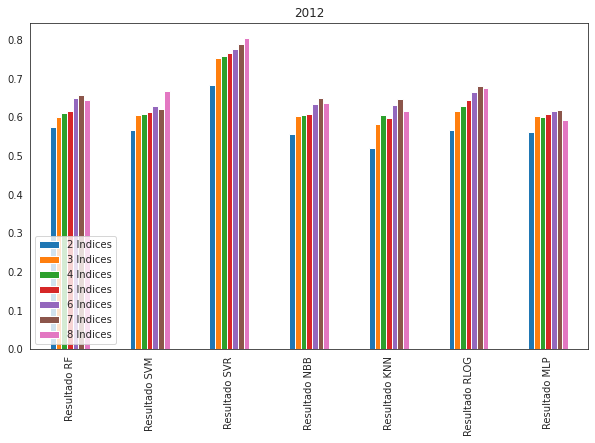

In [ ]:
colunas_dropadas = ['Sentimento', 'Ano', 'Tipo', 'Indices']
indice = comb9.drop(colunas_dropadas, axis=1).columns
ano = 2012
b = pd.DataFrame(
    {'2 Indices': comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '3 Indices': comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '4 Indices': comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '5 Indices': comb5.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '6 Indices': comb6.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '7 Indices': comb7.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],     
     '8 Indices': comb8.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano]     
     
     }, index=indice
)
b.plot(kind='bar', title=ano, figsize=(10,6)).legend(loc='lower left')

In [ ]:
(b * 100).round(2)

,2 Indices,3 Indices,4 Indices,5 Indices,6 Indices,7 Indices,8 Indices
Resultado RF,57.47,60.03,61.06,61.52,64.79,65.58,64.39
Resultado SVM,56.60,60.35,60.61,61.26,62.77,61.90,66.67
Resultado SVR,68.07,75.25,75.71,76.58,77.49,78.90,80.30
Resultado NBB,55.41,60.14,60.56,60.76,63.20,64.83,63.64
Resultado KNN,51.84,58.04,60.37,59.72,63.02,64.50,61.36
Resultado RLOG,56.49,61.40,62.79,64.20,66.27,67.86,67.42
Resultado MLP,55.95,60.14,59.94,60.61,61.36,61.80,59.09


In [ ]:
ano = 2012
c = pd.Series(
    {'2 Indices': round((comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '3 Indices': round((comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '4 Indices': round((comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '5 Indices': round((comb5.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '6 Indices': round((comb6.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '7 Indices': round((comb7.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '8 Indices': round((comb8.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2)     
     
    }
)
c.sort_values(ascending=False)

7 Indices    66.48
8 Indices    66.13
6 Indices    65.56
5 Indices    63.52
4 Indices    63.01
3 Indices    62.19
2 Indices    57.41
dtype: float64

#### 2013

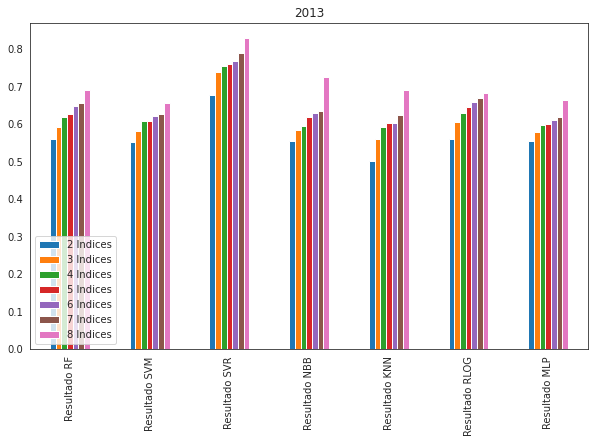

In [ ]:
colunas_dropadas = ['Sentimento', 'Ano', 'Tipo', 'Indices']
indice = comb9.drop(colunas_dropadas, axis=1).columns
ano = 2013
b = pd.DataFrame(
    {'2 Indices': comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '3 Indices': comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '4 Indices': comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '5 Indices': comb5.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '6 Indices': comb6.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '7 Indices': comb7.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],     
     '8 Indices': comb8.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano]     
     
     }, index=indice
)
b.plot(kind='bar', title=ano, figsize=(10,6)).legend(loc='lower left')

In [ ]:
(b * 100).round(2)

,2 Indices,3 Indices,4 Indices,5 Indices,6 Indices,7 Indices,8 Indices
Resultado RF,55.79,59.03,61.85,62.46,64.66,65.39,68.97
Resultado SVM,55.05,58.05,60.69,60.71,61.90,62.68,65.52
Resultado SVR,67.73,73.69,75.34,75.86,76.60,78.94,82.76
Resultado NBB,55.42,58.29,59.48,61.77,62.89,63.42,72.41
Resultado KNN,50.12,55.79,59.14,60.05,60.10,62.19,68.97
Resultado RLOG,55.79,60.47,62.93,64.33,65.80,66.87,68.10
Resultado MLP,55.30,57.80,59.75,59.93,61.08,61.82,66.38


In [ ]:
ano = 2013
c = pd.Series(
    {'2 Indices': round((comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '3 Indices': round((comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '4 Indices': round((comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '5 Indices': round((comb5.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '6 Indices': round((comb6.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '7 Indices': round((comb7.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '8 Indices': round((comb8.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2)     
     
    }
)
c.sort_values(ascending=False)

8 Indices    70.44
7 Indices    65.90
6 Indices    64.72
5 Indices    63.59
4 Indices    62.74
3 Indices    60.44
2 Indices    56.46
dtype: float64

#### 2014

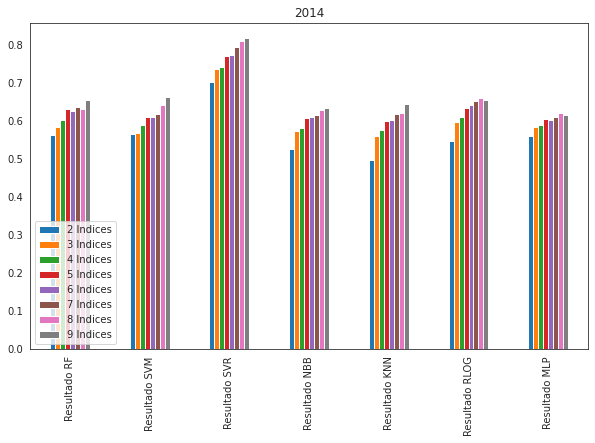

In [ ]:
colunas_dropadas = ['Sentimento', 'Ano', 'Tipo', 'Indices']
indice = comb9.drop(colunas_dropadas, axis=1).columns
ano = 2014
b = pd.DataFrame(
    {'2 Indices': comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '3 Indices': comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '4 Indices': comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '5 Indices': comb5.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '6 Indices': comb6.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '7 Indices': comb7.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],     
     '8 Indices': comb8.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],     
     '9 Indices': comb9.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano]
     }, index=indice
)
b.plot(kind='bar', title=ano, figsize=(10,6)).legend(loc='lower left')

In [ ]:
(b * 100).round(2)

,2 Indices,3 Indices,4 Indices,5 Indices,6 Indices,7 Indices,8 Indices,9 Indices
Resultado RF,56.25,58.24,60.32,63.17,62.62,63.67,63.10,65.38
Resultado SVM,56.61,56.80,58.98,60.96,61.09,61.74,64.06,66.35
Resultado SVR,70.31,73.66,74.26,76.95,77.40,79.53,80.89,81.73
Resultado NBB,52.52,57.21,58.22,60.66,60.99,61.47,62.86,63.46
Resultado KNN,49.76,55.98,57.61,59.85,60.23,61.81,62.14,64.42
Resultado RLOG,54.57,59.68,61.09,63.30,64.06,65.11,65.99,65.38
Resultado MLP,55.89,58.38,58.86,60.34,60.22,60.95,62.14,61.54


In [ ]:
ano = 2014
c = pd.Series(
    {'2 Indices': round((comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '3 Indices': round((comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '4 Indices': round((comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '5 Indices': round((comb5.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '6 Indices': round((comb6.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '7 Indices': round((comb7.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '8 Indices': round((comb8.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '9 Indices': round((comb9.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2)     
     
    }
)
c.sort_values(ascending=False)

9 Indices    66.90
8 Indices    65.88
7 Indices    64.90
6 Indices    63.80
5 Indices    63.60
4 Indices    61.33
3 Indices    59.99
2 Indices    56.56
dtype: float64

#### 2015

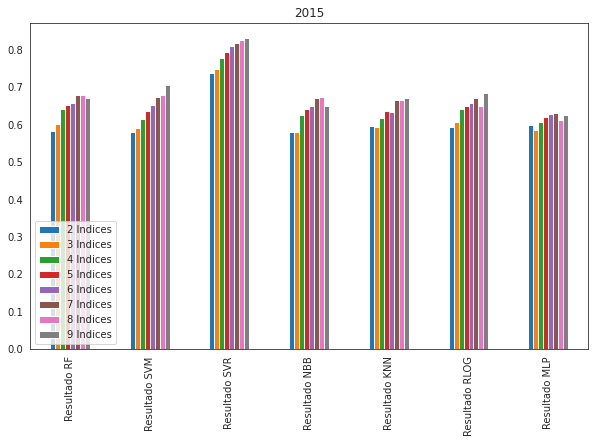

In [ ]:
colunas_dropadas = ['Sentimento', 'Ano', 'Tipo', 'Indices']
indice = comb9.drop(colunas_dropadas, axis=1).columns
ano = 2015
b = pd.DataFrame(
    {'2 Indices': comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '3 Indices': comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '4 Indices': comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '5 Indices': comb5.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '6 Indices': comb6.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '7 Indices': comb7.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],     
     '8 Indices': comb8.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],     
     '9 Indices': comb9.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano]
     }, index=indice
)
b.plot(kind='bar', title=ano, figsize=(10,6)).legend(loc='lower left')

In [ ]:
(b * 100).round(2)

,2 Indices,3 Indices,4 Indices,5 Indices,6 Indices,7 Indices,8 Indices,9 Indices
Resultado RF,58.10,59.98,64.04,65.00,65.62,67.90,67.76,67.05
Resultado SVM,57.95,58.93,61.44,63.46,65.10,67.21,67.90,70.45
Resultado SVR,73.58,74.63,77.54,79.24,80.93,81.57,82.39,82.95
Resultado NBB,57.95,57.83,62.48,64.04,64.85,66.88,67.19,64.77
Resultado KNN,59.38,59.25,61.73,63.57,63.25,66.56,66.48,67.05
Resultado RLOG,59.23,60.51,64.00,64.77,65.69,66.88,64.77,68.18
Resultado MLP,59.66,58.40,60.69,61.85,62.72,62.87,61.08,62.50


In [ ]:
ano = 2015
c = pd.Series(
    {'2 Indices': round((comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '3 Indices': round((comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '4 Indices': round((comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '5 Indices': round((comb5.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '6 Indices': round((comb6.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '7 Indices': round((comb7.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '8 Indices': round((comb8.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '9 Indices': round((comb9.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2)     
     
    }
)
c.sort_values(ascending=False)

9 Indices    68.99
7 Indices    68.55
8 Indices    68.22
6 Indices    66.88
5 Indices    65.99
4 Indices    64.56
3 Indices    61.36
2 Indices    60.84
dtype: float64

#### 2016

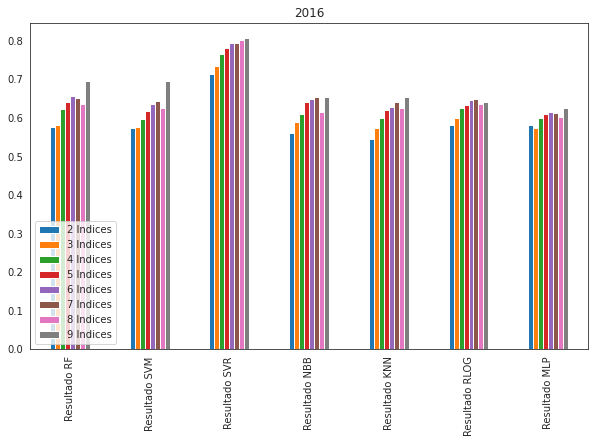

In [ ]:
colunas_dropadas = ['Sentimento', 'Ano', 'Tipo', 'Indices']
indice = comb9.drop(colunas_dropadas, axis=1).columns
ano = 2016
b = pd.DataFrame(
    {'2 Indices': comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '3 Indices': comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '4 Indices': comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '5 Indices': comb5.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '6 Indices': comb6.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '7 Indices': comb7.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],     
     '8 Indices': comb8.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],     
     '9 Indices': comb9.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano]
     }, index=indice
)
b.plot(kind='bar', title=ano, figsize=(10,6)).legend(loc='lower left')

In [ ]:
(b * 100).round(2)

,2 Indices,3 Indices,4 Indices,5 Indices,6 Indices,7 Indices,8 Indices,9 Indices
Resultado RF,57.47,58.04,62.08,64.01,65.60,65.13,63.37,69.44
Resultado SVM,57.29,57.39,59.57,61.73,63.49,64.19,62.33,69.44
Resultado SVR,71.35,73.31,76.56,78.10,79.29,79.22,80.03,80.56
Resultado NBB,55.90,58.93,60.89,63.91,64.71,65.43,61.46,65.28
Resultado KNN,54.34,57.34,59.90,61.96,62.70,63.89,62.33,65.28
Resultado RLOG,57.99,59.92,62.48,63.33,64.53,64.73,63.54,63.89
Resultado MLP,57.99,57.29,59.87,60.77,61.53,61.06,60.07,62.50


In [ ]:
ano = 2016
c = pd.Series(
    {'2 Indices': round((comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '3 Indices': round((comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '4 Indices': round((comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '5 Indices': round((comb5.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '6 Indices': round((comb6.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '7 Indices': round((comb7.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '8 Indices': round((comb8.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '9 Indices': round((comb9.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2)     
     
    }
)
c.sort_values(ascending=False)

9 Indices    68.06
7 Indices    66.23
6 Indices    65.98
5 Indices    64.83
8 Indices    64.73
4 Indices    63.05
3 Indices    60.32
2 Indices    58.90
dtype: float64

#### 2017

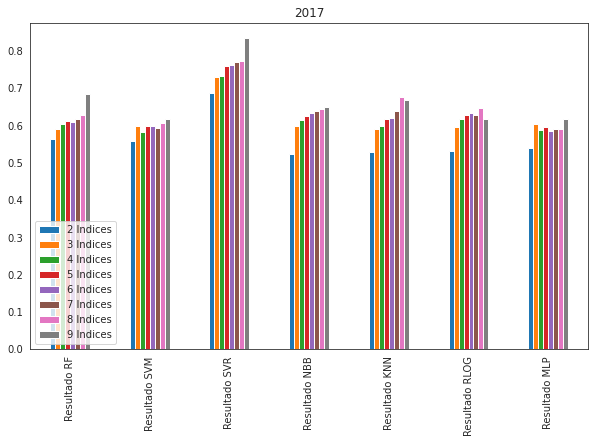

In [ ]:
colunas_dropadas = ['Sentimento', 'Ano', 'Tipo', 'Indices']
indice = comb9.drop(colunas_dropadas, axis=1).columns
ano = 2017
b = pd.DataFrame(
    {'2 Indices': comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '3 Indices': comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '4 Indices': comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '5 Indices': comb5.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '6 Indices': comb6.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '7 Indices': comb7.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],     
     '8 Indices': comb8.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],     
     '9 Indices': comb9.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano]
     }, index=indice
)
b.plot(kind='bar', title=ano, figsize=(10,6)).legend(loc='lower left')

In [ ]:
(b * 100).round(2)

,2 Indices,3 Indices,4 Indices,5 Indices,6 Indices,7 Indices,8 Indices,9 Indices
Resultado RF,56.25,59.05,60.24,61.02,60.95,61.73,62.71,68.33
Resultado SVM,55.63,59.64,58.07,59.74,59.88,59.17,60.62,61.67
Resultado SVR,68.54,73.04,73.27,75.93,76.16,76.85,77.08,83.33
Resultado NBB,52.29,59.76,61.25,62.50,63.27,63.69,64.38,65.00
Resultado KNN,52.92,58.87,59.76,61.69,61.90,63.87,67.50,66.67
Resultado RLOG,53.13,59.58,61.70,62.69,63.21,62.80,64.58,61.67
Resultado MLP,53.75,60.42,58.72,59.38,58.51,58.93,58.96,61.67


In [ ]:
ano = 2017
c = pd.Series(
    {'2 Indices': round((comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '3 Indices': round((comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '4 Indices': round((comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '5 Indices': round((comb5.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '6 Indices': round((comb6.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '7 Indices': round((comb7.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '8 Indices': round((comb8.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '9 Indices': round((comb9.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2)     
     
    }
)
c.sort_values(ascending=False)

9 Indices    66.90
8 Indices    65.12
7 Indices    63.86
6 Indices    63.41
5 Indices    63.28
4 Indices    61.86
3 Indices    61.48
2 Indices    56.07
dtype: float64

#### 2018

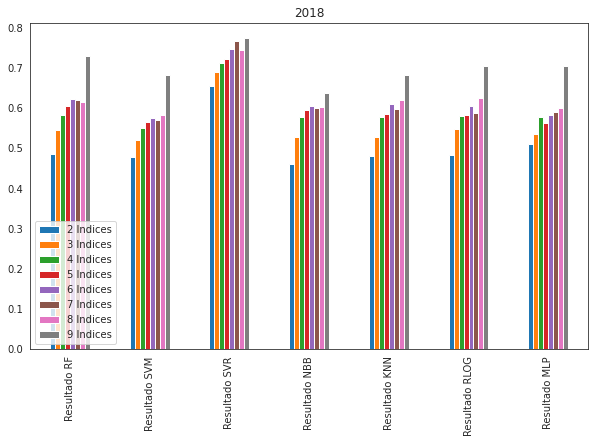

In [ ]:
colunas_dropadas = ['Sentimento', 'Ano', 'Tipo', 'Indices']
indice = comb9.drop(colunas_dropadas, axis=1).columns
ano = 2018
b = pd.DataFrame(
    {'2 Indices': comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '3 Indices': comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '4 Indices': comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '5 Indices': comb5.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '6 Indices': comb6.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],
     '7 Indices': comb7.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],     
     '8 Indices': comb8.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano],     
     '9 Indices': comb9.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano]
     }, index=indice
)
b.plot(kind='bar', title=ano, figsize=(10,6)).legend(loc='lower left')

In [ ]:
(b * 100).round(2)

,2 Indices,3 Indices,4 Indices,5 Indices,6 Indices,7 Indices,8 Indices,9 Indices
Resultado RF,48.58,54.55,58.28,60.52,62.05,61.77,61.36,72.73
Resultado SVM,47.73,51.95,54.87,56.53,57.51,56.98,58.24,68.18
Resultado SVR,65.34,68.83,71.14,71.98,74.63,76.62,74.43,77.27
Resultado NBB,46.02,52.68,57.59,59.29,60.43,59.82,60.23,63.64
Resultado KNN,48.01,52.76,57.71,58.51,60.84,59.74,61.93,68.18
Resultado RLOG,48.30,54.71,57.91,58.08,60.43,58.60,62.50,70.45
Resultado MLP,50.85,53.49,57.59,56.17,58.12,58.93,59.94,70.45


In [ ]:
ano = 2018
c = pd.Series(
    {'2 Indices': round((comb2.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '3 Indices': round((comb3.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '4 Indices': round((comb4.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),
     '5 Indices': round((comb5.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '6 Indices': round((comb6.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '7 Indices': round((comb7.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '8 Indices': round((comb8.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2),     
     '9 Indices': round((comb9.drop(['Indices', 'Sentimento','Tipo'],axis=1).groupby(['Ano']).mean().loc[ano].mean()*100),2)     
     
    }
)
c.sort_values(ascending=False)

9 Indices    70.13
8 Indices    62.66
6 Indices    62.00
7 Indices    61.78
5 Indices    60.15
4 Indices    59.30
3 Indices    55.57
2 Indices    50.69
dtype: float64

#### Outros

In [ ]:
c = pd.Series(
    {'2 Indices': round((comb2.drop(['Indices', 'Sentimento','Tipo', 'Ano'],axis=1).mean().mean()*100),2),
     '3 Indices': round((comb3.drop(['Indices', 'Sentimento','Tipo', 'Ano'],axis=1).mean().mean()*100),2),
     '4 Indices': round((comb4.drop(['Indices', 'Sentimento','Tipo', 'Ano'],axis=1).mean().mean()*100),2),
     '5 Indices': round((comb5.drop(['Indices', 'Sentimento','Tipo', 'Ano'],axis=1).mean().mean()*100),2),     
     '6 Indices': round((comb6.drop(['Indices', 'Sentimento','Tipo', 'Ano'],axis=1).mean().mean()*100),2),     
     '7 Indices': round((comb7.drop(['Indices', 'Sentimento','Tipo', 'Ano'],axis=1).mean().mean()*100),2),     
     '8 Indices': round((comb8.drop(['Indices', 'Sentimento','Tipo', 'Ano'],axis=1).mean().mean()*100),2),     
     '9 Indices': round((comb9.drop(['Indices', 'Sentimento','Tipo', 'Ano'],axis=1).mean().mean()*100),2),     

    }
)
c.sort_values(ascending=False)

9 Indices    68.20
8 Indices    65.95
7 Indices    65.71
6 Indices    65.35
5 Indices    64.65
4 Indices    63.47
3 Indices    61.37
2 Indices    57.69
dtype: float64

# Rascunhos

In [ ]:


X_train = StandardScaler().fit_transform(x_train)
X_test = StandardScaler().fit_transform(x_test)
model = Sequential()
model.add(LSTM(2, input_shape=(x_train.shape[1], 1)))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.fit(X_train[:, :, np.newaxis], y_train, epochs=100)
y_pred = model.predict(X_test[:, :, np.newaxis])


Epoch 1/100
5/5 [==============================] - 2s 5ms/step - loss: 0.6480 - acc: 0.4923
Epoch 2/100
5/5 [==============================] - 0s 4ms/step - loss: 0.6432 - acc: 0.5136
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 0.6277 - acc: 0.4222
Epoch 4/100
5/5 [==============================] - 0s 3ms/step - loss: 0.6277 - acc: 0.4252
Epoch 5/100
5/5 [==============================] - 0s 3ms/step - loss: 0.6242 - acc: 0.3698
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.6173 - acc: 0.3889
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.6122 - acc: 0.4123
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.5996 - acc: 0.3413
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.5981 - acc: 0.3873
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.5993 - acc: 0.3607
Epoch 11/100
5/5 [==============================] - 0s 4ms/step - loss: 0.5836 

In [ ]:
y_pred

array([[0.25335774],
       [0.2572652 ],
       [0.15367588],
       [0.22841486],
       [0.14195096],
       [0.25335774],
       [0.53757226],
       [0.30684042],
       [0.53757226],
       [0.53757226],
       [0.14195096],
       [0.30684042],
       [0.11056516],
       [0.5765331 ],
       [0.06977075],
       [0.37959093],
       [0.30684042],
       [0.5765331 ],
       [0.53757226],
       [0.06977075],
       [0.22841486],
       [0.25335774],
       [0.14195096],
       [0.09216601],
       [0.11056516],
       [0.06185511],
       [0.15367588],
       [0.06706312],
       [0.11484727],
       [0.06706312],
       [0.5765331 ],
       [0.07330668],
       [0.25335774],
       [0.34069097],
       [0.53757226],
       [0.08598089]], dtype=float32)

In [ ]:

X_train = StandardScaler().fit_transform(x_train)
X_test = StandardScaler().fit_transform(x_test)
model = Sequential()
model.add(Dense(2, activation="relu", input_shape=(x_train.shape[1],)))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.fit(x_train, y_train, epochs=100)
y_pred = model.predict(x_test)
print(accuracy_score(y_test, y_pred > 0.5))

Epoch 1/100
5/5 [==============================] - 1s 3ms/step - loss: 0.5964 - acc: 0.0240
Epoch 2/100
5/5 [==============================] - 0s 3ms/step - loss: 0.5353 - acc: 0.0000e+00
Epoch 3/100
5/5 [==============================] - 0s 3ms/step - loss: 0.3876 - acc: 0.0000e+00
Epoch 4/100
5/5 [==============================] - 0s 3ms/step - loss: 0.4528 - acc: 0.0000e+00
Epoch 5/100
5/5 [==============================] - 0s 2ms/step - loss: 0.5292 - acc: 0.0000e+00
Epoch 6/100
5/5 [==============================] - 0s 3ms/step - loss: 0.6052 - acc: 0.0000e+00
Epoch 7/100
5/5 [==============================] - 0s 3ms/step - loss: 0.5399 - acc: 0.0000e+00
Epoch 8/100
5/5 [==============================] - 0s 2ms/step - loss: 0.5167 - acc: 0.0000e+00
Epoch 9/100
5/5 [==============================] - 0s 3ms/step - loss: 0.4696 - acc: 0.0000e+00
Epoch 10/100
5/5 [==============================] - 0s 2ms/step - loss: 0.5390 - acc: 0.0000e+00
Epoch 11/100
5/5 [=========================